In [1]:
import pandas as pd
# from pandasai import SmartDataframe
# from pandasai.llm.openai import OpenAI

import numpy as np
import os
import sys
import json
import requests
import gc
from tqdm import tqdm
from datetime import datetime, timedelta
import datetime as dt
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

import statsmodels
import scipy.stats as ss
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# # MacOS에서 한글 폰트 설정
# mpl.rcParams['font.family'] = 'AppleGothic'
# mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지

# # 테스트 그래프
# plt.title('테스트: 한글 표시')
# plt.plot([1, 2, 3], [4, 5, 6])
# plt.show()
# pd.options.display.max_columns = 100
# pd.options.display.max_rows=1000


# pd.options.display.max_columns = 100
# pd.options.display.max_rows=1000


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

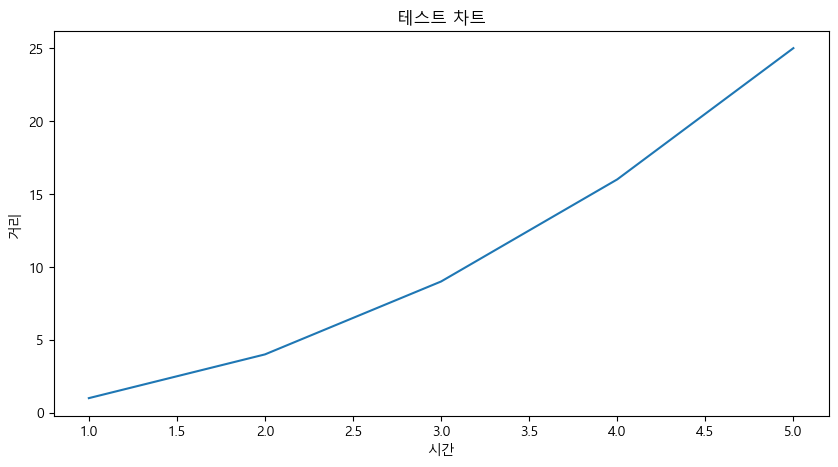

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 경로 직접 지정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕의 경로
font_prop = fm.FontProperties(fname=font_path, size=12)

# 전역 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕으로 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 테스트 차트
plt.figure(figsize=(10, 5))
plt.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25])
plt.title('테스트 차트')
plt.xlabel('시간')
plt.ylabel('거리')
plt.show()


In [4]:
df = pd.read_csv('../result/result_0403_0509.csv')
# df = pd.read_excel('../result/result_0403_0509.xlsx',engine='openpyxl')
df['orderDate'] = pd.to_datetime(df['orderDate'],format='%Y%m%d')
df['click_time'] = df['subParam'].str.split('_').str.get(1)
df['subParam'] = df['subParam'].str.split('_').str.get(0)

In [5]:
df.subParam.nunique()

26905

## 분석 개요
1. 구매 범위가 너무 넓음. 아웃라이어를 초 VIP 구간으로 넣고, 나머지 평균을 구간화 하기
2. 유저 클릭 시간대 분포와 매출간의 상관성과 분포 보기
3. 유저 아이디 <> MMP 행동 매칭해서, 회귀분석
4. 재방문과 재구매와의 상관관계 보고, uplift 확인하기

## 아웃라이어 처리

In [5]:
# 시간 분포를 위한 로데이터 복제

td = df.query('click_time.notna()')

In [6]:
# 집계 및 아웃라이어 처리
df = df[(df['subParam'].notna()) & (df['subParam']!="0")]
df = df.query("subParam.notna()").groupby('subParam').agg({'total_gmv':'sum','total_commission':'sum','total_quantity':'sum','orderDate':'count'}).reset_index()
df = df[df['total_gmv']>0]

df['zscore'] = ss.zscore(df['total_gmv'])

# zscore > 3 이 일반적이지만, 1로 축소하여 컷. 5% 아웃라이어, 95% 대부분 모수
df['outlier'] = df['zscore'].abs() > 1
print('outlier : ', len(df.query('outlier == True')))
print('outlier ratio : ', len(df.query('outlier == True')) / len(df) )

tt = df.query('outlier == False')
ss = df.query('outlier == True')

outlier :  1413
outlier ratio :  0.054387990762124715


In [24]:
len(df)

25980

In [7]:
normal = tt.subParam.unique().tolist()
outlier = ss.subParam.unique().tolist()

In [ ]:
# ss.groupby('subParam')[['total_gmv']].sum().sort_values(by='total_gmv',ascending=True)

In [ ]:
# tt.query("subParam.isin(@normal)").groupby('subParam')[['total_gmv']].sum().sort_values(by='total_gmv',ascending=True)

### 시간 매출 분포

In [28]:

# 유저 아이디가 있는 아웃라이어/정상 유저들로 필터링

tt_tmp = td.query("subParam.isin(@normal)")
ss_tmp = td.query("subParam.isin(@outlier)")

len(tt_tmp), len(ss_tmp)

(21735, 4673)

In [128]:
tt_tmp.head()

,Unnamed: 0,orderDate,trackingCode,subId,subParam,addtag,ctag,orderId,productId,productName,...,commissionRate,commission,date,refund_quantity,refund_gmv,refund_commission,total_gmv,total_commission,total_quantity,click_time
51567,51567,2024-04-22,AF3155932,homecoin,2458d9ad-8812-457b-ad1e-18b08247d30e,460,7923479215,8914945818459669,5498043828,돌 바나나,...,5.25,249.0,0,0.0,0.0,0.0,4740.0,249.0,1.0,20240422195729
51576,51576,2024-04-22,AF3155932,homecoin,dbeb8205-d8b2-45c8-9456-fece8d932ea1,460,6388340244,8264948118149767,1910832435,키쉬 1종 주방 앤 젖병세제,...,5.25,586.0,0,0.0,0.0,0.0,11160.0,586.0,1.0,20240422170329
51577,51577,2024-04-22,AF3155932,homecoin,1a204e83-c3f5-43e7-ae71-cb60ac41c1ef,460,7484253365,8654947118339749,226236497,문봉 푸주 건두부면,...,5.25,455.0,0,0.0,0.0,0.0,8660.0,455.0,1.0,20240422234024
51579,51579,2024-04-22,AF3155932,homecoin,2b9d174b-485f-4e3a-bcd5-d83ff6543d77,460,7558679993,8924943918749217,5374328047,수성 멸균탈지면봉 10cm 2p,...,5.25,257.0,0,0.0,0.0,0.0,4880.0,257.0,1.0,20240422211050
51588,51588,2024-04-22,AF3155932,homecoin,905aa444-3b1e-43d2-b753-9bda257640dc,460,7687919564,8654947018089852,7319912616,주디앤 여성 애플턴 반팔 세미크롭 티셔츠 3P,...,5.25,993.0,0,0.0,0.0,0.0,18900.0,993.0,1.0,20240422220601


In [31]:
import pandas as pd

def get_date(df):
    # Ensure click_time is a datetime object and check the first few entries
    df['click_time_dt'] = pd.to_datetime(df['click_time'])

    
    # Floor the datetime to the nearest hour and format
    df['hour_range'] = df['click_time_dt'].dt.floor('H').dt.strftime('%H')

    
    # Map the weekdays
    weekday_list = ['월','화','수','목','금','토','일']
    df['day'] = df['click_time_dt'].dt.weekday
    df['day_d'] = df['day'].apply(lambda x: weekday_list[x])
    
    
    return df

normal_1 = get_date(tt_tmp)
outlier_1 = get_date(ss_tmp)


In [43]:
normal_1 = normal_1.query("orderDate <='2024-05-05' ")
outlier_1 = outlier_1.query("orderDate <='2024-05-05' ")

그룹바이를 안해서 차트가 이상함. 다시 그룹바이하기

In [44]:
def gropupping(key,value):
    normal_1.groupby([key,'subParam'])[[value]].sum()


In [80]:
norm_tt

,day,day_d,day_count,commission
0,0,월,2574,1770192.0
1,1,화,2860,1914190.0
2,2,수,2992,2021145.0
3,3,목,2474,1814430.0
4,4,금,2410,1680192.0
5,5,토,2070,1361363.0
6,6,일,1490,935002.0


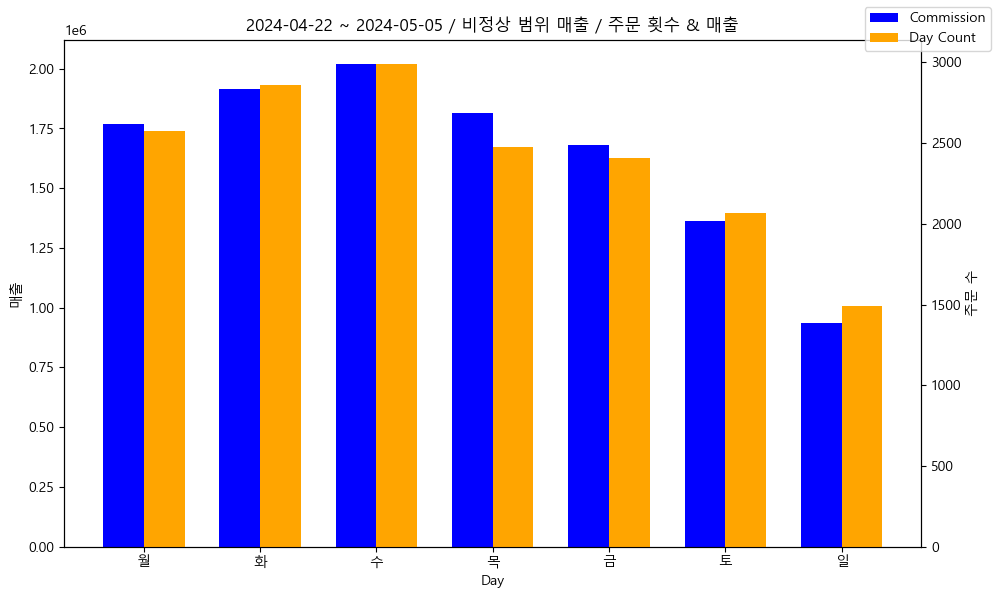

In [93]:
norm_tt = normal_1.groupby(['day', 'day_d']).agg(day_count=('day_d', 'count'), commission=('total_commission','sum')).reset_index()


# Prepare your data
categories = norm_tt['day_d']  # assuming this column holds the weekday names
n_categories = len(categories)

# Positioning constants
bar_width = 0.35
indices = np.arange(n_categories)  # the x locations for the groups

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the 'commission' on the first axis
commission_bars = ax1.bar(indices - bar_width/2, norm_tt['commission'], bar_width, label='Commission', color='blue')
ax1.set_xlabel('Day')
ax1.set_ylabel('매출', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(indices)
ax1.set_xticklabels(categories)

# Create a second y-axis for the 'day_count'
ax2 = ax1.twinx()
day_count_bars = ax2.bar(indices + bar_width/2, norm_tt['day_count'], bar_width, label='Day Count', color='orange')
ax2.set_ylabel('주문 수', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and adjust layout
plt.title('2024-04-22 ~ 2024-05-05 / 비정상 범위 매출 / 주문 횟수 & 매출')
fig.tight_layout()

# Adding legend
handles, labels = [], []
for ax in [ax1, ax2]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
fig.legend(handles, labels, loc='upper right')

plt.show()

In [98]:
norm_tt

,hour_range,day_count,commission
0,01,11,8255.0
1,02,6,8206.0
2,05,1,1281.0
3,06,5,10446.0
4,07,24,25910.0
5,08,33,38290.0
6,09,38,56588.0
7,10,68,124465.0
8,11,92,91294.0
9,12,88,188742.0


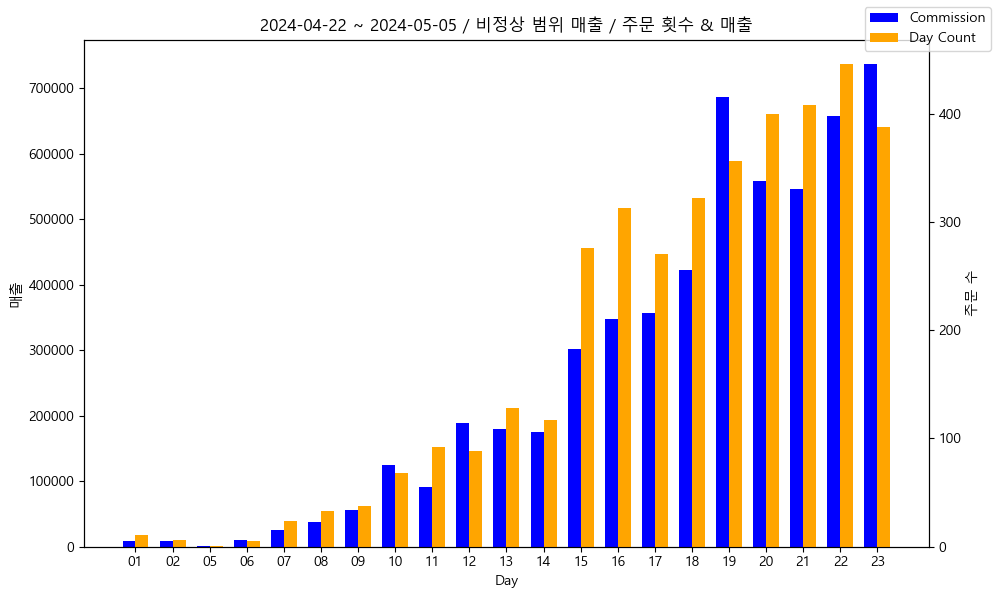

In [99]:

norm_tt = outlier_1.groupby(['hour_range']).agg(day_count=('day_d', 'count'), commission=('total_commission','sum')).reset_index()


# Prepare your data
categories = norm_tt['hour_range']  # assuming this column holds the weekday names
n_categories = len(categories)

# Positioning constants
bar_width = 0.35
indices = np.arange(n_categories)  # the x locations for the groups

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the 'commission' on the first axis
commission_bars = ax1.bar(indices - bar_width/2, norm_tt['commission'], bar_width, label='Commission', color='blue')
ax1.set_xlabel('Day')
ax1.set_ylabel('매출', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(indices)
ax1.set_xticklabels(categories)

# Create a second y-axis for the 'day_count'
ax2 = ax1.twinx()
day_count_bars = ax2.bar(indices + bar_width/2, norm_tt['day_count'], bar_width, label='Day Count', color='orange')
ax2.set_ylabel('주문 수', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and adjust layout
plt.title('2024-04-22 ~ 2024-05-05 / 비정상 범위 매출 / 주문 횟수 & 매출')
fig.tight_layout()

# Adding legend
handles, labels = [], []
for ax in [ax1, ax2]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
fig.legend(handles, labels, loc='upper right')

plt.show()

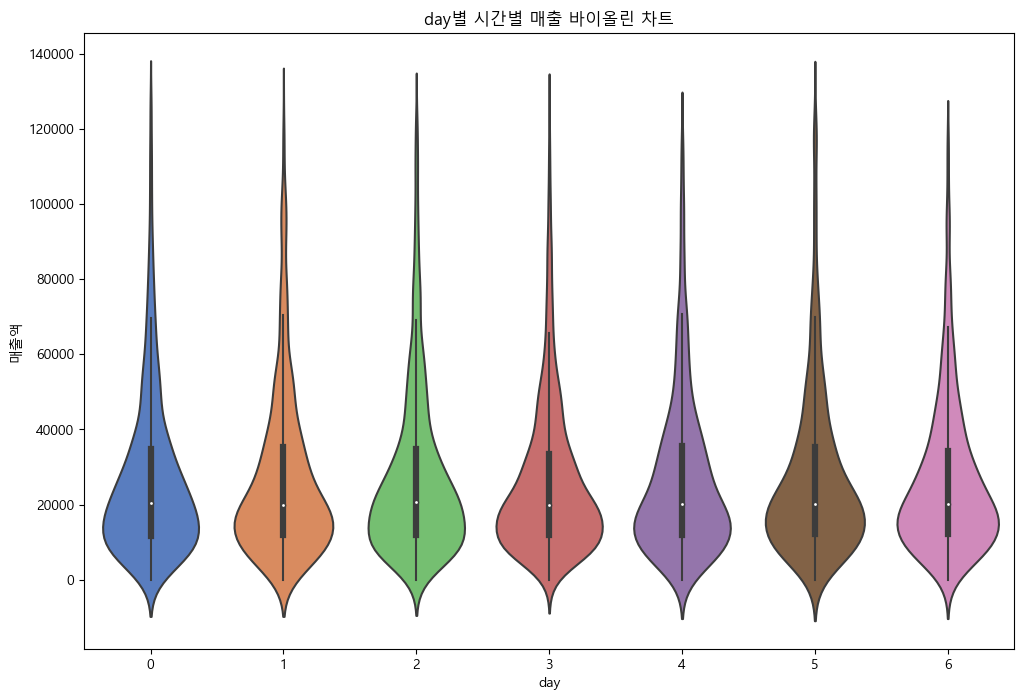

In [33]:
def get_chart_violin(df):
    # 바이올린 차트 그리
    df = normal_1.groupby(['day','hour_range','subParam'])[['total_gmv']].sum().reset_index()

    plt.figure(figsize=(12, 8))
    sns.violinplot(x='day', y='total_gmv',  data=df, palette='muted', split=True)
    plt.title('day별 시간별 매출 바이올린 차트')
    plt.xlabel('day')
    plt.ylabel('매출액')
    plt.show()
    
get_chart_violin(normal_1)

In [ ]:
normal_1.columns

Index(['Unnamed: 0', 'orderDate', 'trackingCode', 'subId', 'subParam',
       'addtag', 'ctag', 'orderId', 'productId', 'productName', 'quantity',
       'gmv', 'commissionRate', 'commission', 'date', 'refund_quantity',
       'refund_gmv', 'refund_commission', 'total_gmv', 'total_commission',
       'total_quantity', 'click_time', 'hour_range', 'day'],
      dtype='object')

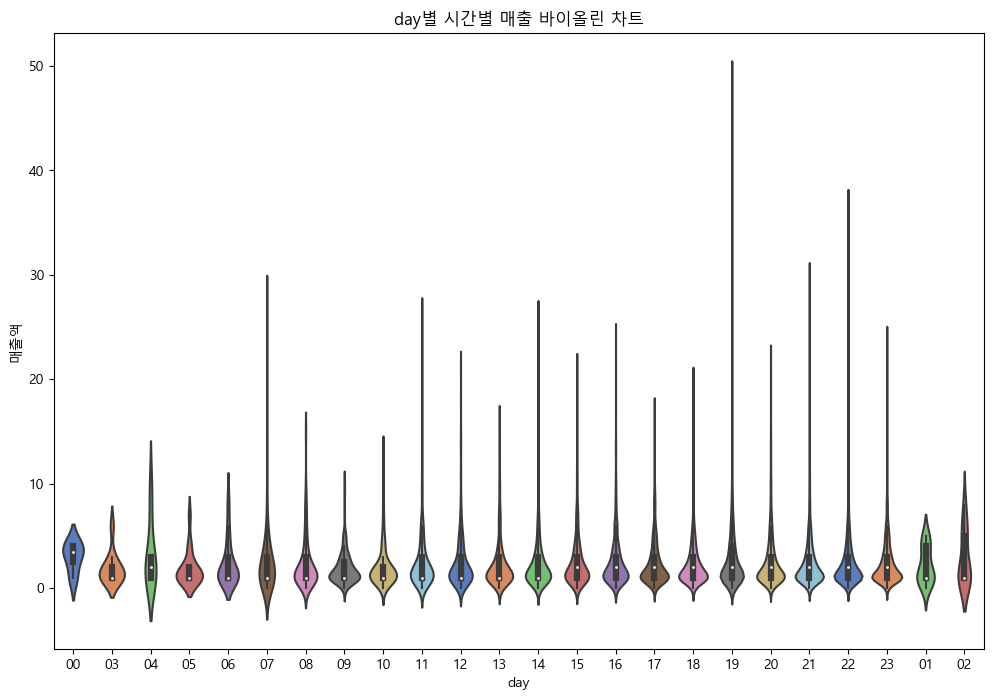

In [ ]:
def get_chart_violin(df):
    # 바이올린 차트 그리
    df = normal_1.groupby(['day','hour_range','subParam'])[['total_quantity']].sum().reset_index()

    plt.figure(figsize=(12, 8))
    sns.violinplot(x='hour_range', y='total_quantity',  data=df, palette='muted', split=True)
    plt.title('day별 시간별 매출 바이올린 차트')
    plt.xlabel('day')
    plt.ylabel('매출액')
    plt.show()
    
get_chart_violin(normal_1)

<Axes: xlabel='hour_range', ylabel='total_quantity'>

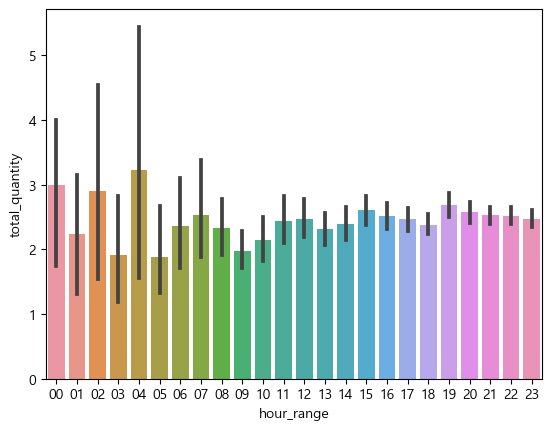

In [ ]:
kde = normal_1.groupby(['day','hour_range','subParam'])[['total_quantity']].sum().reset_index()
kde.sort_values(by='hour_range',inplace=True)
# sns.kdeplot(data=kde, x='hour_range',y='total_quantity')
sns.barplot(data=kde,x='hour_range',y='total_quantity')

<Axes: xlabel='hour_range', ylabel='total_gmv'>

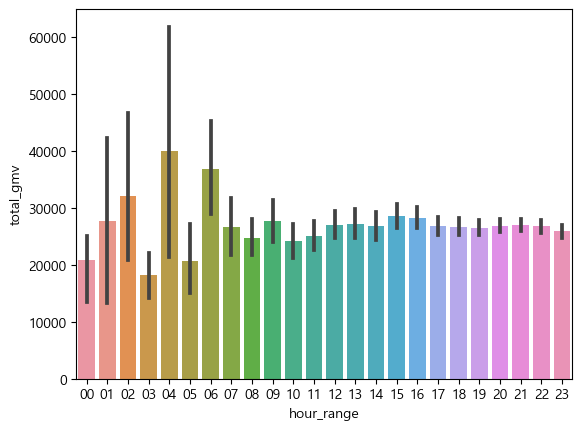

In [ ]:
kde = normal_1.groupby(['day','hour_range','subParam'])[['total_gmv']].sum().reset_index()
kde.sort_values(by='hour_range',inplace=True)
# sns.kdeplot(data=kde, x='hour_range',y='total_quantity')
sns.barplot(data=kde,x='hour_range',y='total_gmv')

<Axes: xlabel='hour_range', ylabel='total_gmv'>

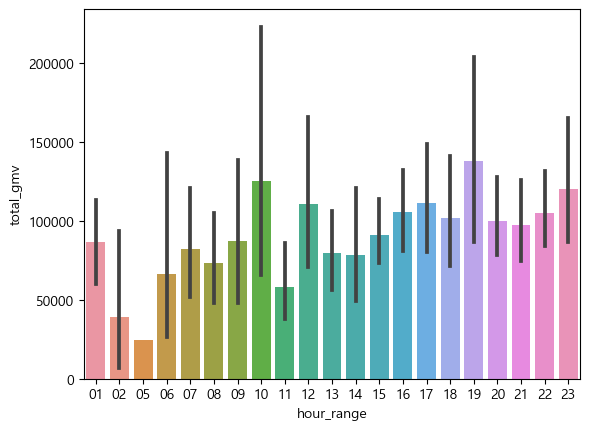

In [ ]:
kde = outlier_1.groupby(['day','hour_range','subParam'])[['total_gmv']].sum().reset_index()
kde.sort_values(by='hour_range',inplace=True)
# sns.kdeplot(data=kde, x='hour_range',y='total_quantity')
sns.barplot(data=kde,x='hour_range',y='total_gmv')

<Axes: xlabel='day', ylabel='total_gmv'>

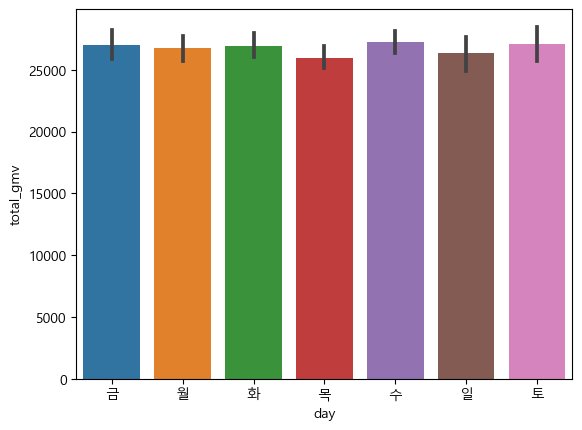

In [ ]:
kde = normal_1.groupby(['day','hour_range','subParam'])[['total_gmv']].sum().reset_index()
kde.sort_values(by='hour_range',inplace=True)
# sns.kdeplot(data=kde, x='hour_range',y='total_quantity')
sns.barplot(data=kde,x='day',y='total_gmv')

<Axes: xlabel='day', ylabel='total_gmv'>

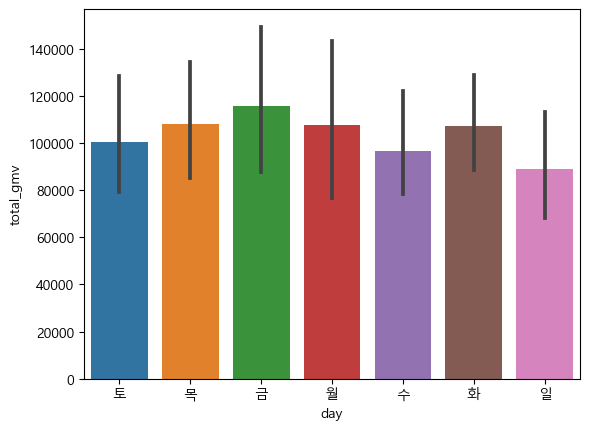

In [ ]:
kde = outlier_1.groupby(['day','hour_range','subParam'])[['total_gmv']].sum().reset_index()
kde.sort_values(by='hour_range',inplace=True)
# sns.kdeplot(data=kde, x='hour_range',y='total_quantity')
sns.barplot(data=kde,x='day',y='total_gmv')

### 구간화

In [ ]:
tt.total_gmv.mean()

33402.39475719461

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


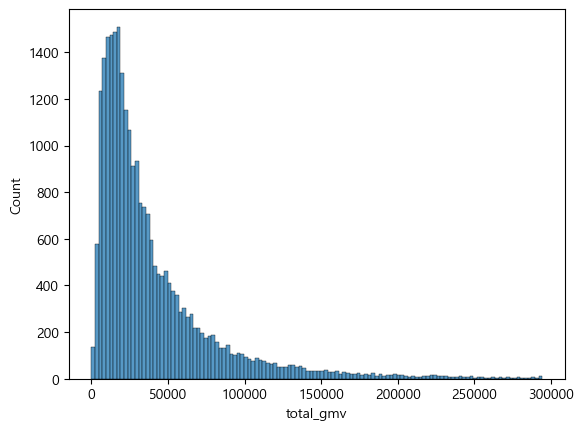

In [ ]:
sns.histplot(tt.total_gmv)
plt.show()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[]

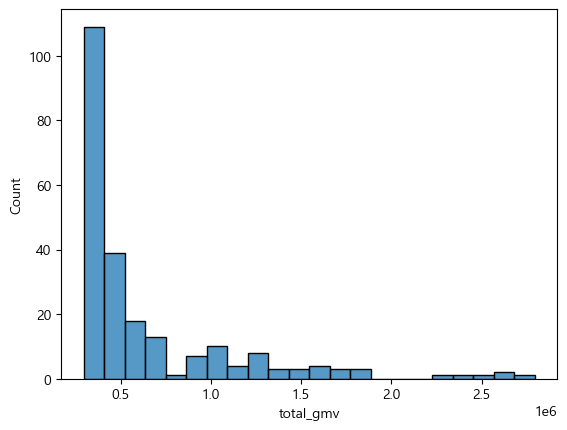

In [ ]:
sns.histplot(ss.total_gmv)
plt.plot()

In [ ]:
tt.describe()


,total_gmv,total_commission,total_quantity,orderDate,zscore
count,25749.000000,25749.000000,25749.000000,25749.000000,25749.000000
mean,40024.954018,2040.160045,3.509496,2.854790,-0.063990
std,40812.439372,2084.610794,3.990497,2.962652,0.490787
min,2.000000,1.000000,0.000000,1.000000,-0.545283
25%,14700.000000,736.000000,1.000000,1.000000,-0.368533
50%,26410.000000,1344.000000,2.000000,2.000000,-0.227716
75%,50010.000000,2555.000000,4.000000,3.000000,0.056084
max,294270.000000,15454.000000,65.000000,53.000000,2.993413


In [ ]:
ss.describe()

,total_gmv,total_commission,total_quantity,orderDate,zscore
count,2.310000e+02,231.000000,231.000000,231.000000,231.000000
mean,6.384912e+05,29698.367965,13.476190,10.108225,7.132816
std,4.879761e+05,23605.243142,17.761906,12.991016,5.868117
min,2.949600e+05,6777.000000,1.000000,1.000000,3.001710
25%,3.389150e+05,16879.000000,2.000000,2.000000,3.530287
50%,4.327800e+05,20723.000000,5.000000,5.000000,4.659053
75%,6.972700e+05,31306.500000,20.500000,14.000000,7.839656
max,2.794200e+06,146696.000000,143.000000,103.000000,33.056114


- 구간화
    - 95%, 2만원단위. 5% 초고액

In [33]:
tt.total_gmv.max()

128500.0

In [26]:
# 구간 범위 설정 (5만원 단위)
bins = np.arange(0, tt['total_gmv'].max() + 20000, 20000)  # 최대값보다 하나 더 많은 구간을 포함하기 위해 추가

# pd.cut을 사용하여 매출 데이터를 구간별로 나누기
labels = [f'{int(i)}원 - {int(j)}원' for i, j in zip(bins[:-1], bins[1:])]  # 레이블 생성
tt['range'] = pd.cut(tt['total_gmv'], bins=bins, labels=labels, right=False)  # 구간 나누기 Normal
ss['range'] = pd.cut(ss['total_gmv'], bins=bins, labels=labels, right=False)  # 구간 나누기 Normal

df = pd.concat([tt,ss],axis=0)
df.range.cat.categories
df['range'] = df['range'].cat.add_categories('140000원 이상')
df['range'].fillna('140000원 이상', inplace=True)

In [27]:
len(df)

25980

In [14]:
df.groupby('range')[['subParam']].count()['subParam'].sum()

25980

In [28]:
df.groupby('range')[['total_gmv']].mean()

,total_gmv
range,
0원 - 20000원,11972.342739
20000원 - 40000원,28821.224407
40000원 - 60000원,49191.973981
60000원 - 80000원,69078.940737
80000원 - 100000원,89174.967402
100000원 - 120000원,109503.432473
120000원 - 140000원,129858.281532
140000원 이상,279614.252823


In [30]:
# df.to_parquet('../result/grp_0403_0509.parquet')
df.to_csv('../result/grp_0403_0509.csv')

In [7]:
cp = pd.read_parquet('../result/grp_0403_0509.parquet')
db = pd.read_csv('../result/user_db.csv')
cp.rename(columns={'subParam':'ID'},inplace=True)
db.rename(columns={'유저아이디':'ID','나이':'age','성별':'sex','가입일':'join_date','총챌린지참여수':'total_ch_join'},inplace=True)


In [25]:
df_1

,ID,tap_go__bf_list,bf_offerwall,coin_reward,cp_reward,chg_reward,chg_reward_cnt,chg_join,cps_reward,spend,spend_cnt,ad_click_no_coupang,ad_click_coupang,avg_visit_interval,total_visits
2713,f6df3127-ae24-4037-b2db-7905004af649,0,0,5.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1
3731,5a369a24-2393-45f6-9b7a-3ce75133c710,0,0,5.0,0.0,0.0,0,0,0.0,0.0,0,0,1,0.0,1
3928,bde57156-a424-4f28-99eb-766fa2403aa0,2,0,27.0,10.0,0.0,0,2,5.0,0.0,0,1,1,0.0,1
5615,d825341c-1a5a-4ce2-9b15-d34164dd165d,0,0,5.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1
5808,fa02c2c2-2c7a-4a19-8c44-cdde3fcf681f,0,0,4.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955813,f37c1dcd-8427-4495-a377-c191ee65e4d3,31,0,973.0,340.0,5393.0,36,17,138.0,19571.0,2,30,24,1.0,37
955822,2610930a-c187-46fa-97db-2f1c9d26b93b,67,1,1005.0,430.0,5130.0,38,15,174.0,3714.0,2,10,25,1.0,37
955829,66ec01df-e194-44d8-829c-fed6f8f535e9,129,157,576.0,400.0,3423.0,29,15,160.0,0.0,0,37,17,1.0,37
955836,6422b38d-e03f-45a9-baf7-aaeab63defed,2,0,649.0,20.0,1834.0,13,15,0.0,0.0,0,11,5,1.0,37


## 행동 데이터와 머지

1. 동 기간동안 유저아이디별 집계된 행동 정보 Merge
2. 매출과의 회귀분석 실행
3. 장바구니 분석
4. 특히, 챌린지 및 earn 금액과 구매간의 상관성 확인

In [334]:
from google.cloud import bigquery
from google.cloud.bigquery import job

PROJCECT = 'ballosodeuk'
bq = bigquery.Client(project=PROJCECT)

# 클라이언트 설정
client = bigquery.Client()

# SQL 파일 읽기
file = '../query/0515_행동데이터.sql'
with open(file, 'r') as file:
    query = file.read()


In [335]:
job_config = bigquery.QueryJobConfig()
query_job = client.query(query, job_config=job_config)

df = query_job.to_dataframe()

In [8]:
# df.to_parquet('../result/0403_0509_MMP_keyfeatures.parquet')
df = pd.read_parquet('../result/0403_0509_MMP_keyfeatures.parquet')

쿠팡 데이터와 머지 테스트

In [9]:
print(f"노출이 0인 로깅 오류 : {round(len(df[df['total_visits']==0]) / len(df[df['total_visits']>0]),2)}")

노출이 0인 로깅 오류 : 0.0


### 걸음적립을 통한 쿠팡 구매자
- 걸음적립을 통한 매출은 총 매출의 약 40%다.
- 챌린지를 통한 캐시 적립은 전체의 약 55%다.
- 걸음적립을 통한 쿠팡 구매자는 라이트 유저이다.
    - 타겟의 92%는 3회 이하의 챌린지 참여 이력이 있다.
    - 타겟의 98%는 3회 이하의 오퍼월 참여 이력이 있다.

-  매출은 걸음 쿠팡 > 오퍼월 순이다.



- 쿠팡 구매자의 92%는 한달동안 3회 이하의 챌린지 참여 이력이 있다.

In [12]:
df_1 = df[df['ID'].isin(cp_id)]


In [353]:
df_1.describe()
df_1.head()


,ID,tap_go__bf_list,bf_offerwall,coin_reward,cp_reward,chg_reward,chg_reward_cnt,chg_join,cps_reward,spend,spend_cnt,ad_click_no_coupang,ad_click_coupang,avg_visit_interval,total_visits
2713,f6df3127-ae24-4037-b2db-7905004af649,0,0,5.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1
3731,5a369a24-2393-45f6-9b7a-3ce75133c710,0,0,5.0,0.0,0.0,0,0,0.0,0.0,0,0,1,0.0,1
3928,bde57156-a424-4f28-99eb-766fa2403aa0,2,0,27.0,10.0,0.0,0,2,5.0,0.0,0,1,1,0.0,1
5615,d825341c-1a5a-4ce2-9b15-d34164dd165d,0,0,5.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1
5808,fa02c2c2-2c7a-4a19-8c44-cdde3fcf681f,0,0,4.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1


<Axes: xlabel='chg_join', ylabel='Count'>

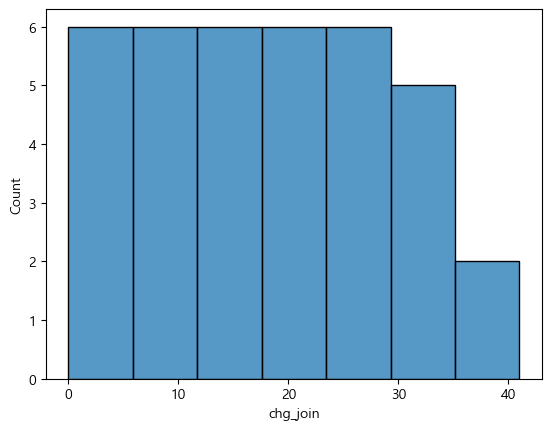

In [367]:
tt = df_1.groupby('chg_join').agg({'ID':'count'}).reset_index()
sns.histplot(tt['chg_join'])

In [21]:
cp_user_ch_join_1 = df[(df['ID'].isin(cp_id)) & (df['join_date']<"2024-04-03")].chg_join.value_counts()[1].sum()
cp_user_ch_join_0 = df[(df['ID'].isin(cp_id)) & (df['join_date']<"2024-04-03")].chg_join.value_counts()[0].sum()
cp_user_ch_join_2 = df[(df['ID'].isin(cp_id)) & (df['join_date']<"2024-04-03")].chg_join.value_counts()[2].sum()
cp_user_ch_join_3 = df[(df['ID'].isin(cp_id)) & (df['join_date']<"2024-04-03")].chg_join.value_counts()[3].sum()
cp_user_ch_join_4 = df[(df['ID'].isin(cp_id)) & (df['join_date']<"2024-04-03")].chg_join.value_counts()[4].sum()
cp_user_ch_join_5 = df[(df['ID'].isin(cp_id)) & (df['join_date']<"2024-04-03")].chg_join.value_counts()[5].sum()
cp_user_ch_join_6 = df[(df['ID'].isin(cp_id)) & (df['join_date']<"2024-04-03")].chg_join.value_counts()[6].sum()
cp_user_ch_join_7 = df[(df['ID'].isin(cp_id)) & (df['join_date']<"2024-04-03")].chg_join.value_counts()[7].sum()
cp_user_ch_join_total = df[(df['ID'].isin(cp_id)) & (df['join_date']<"2024-04-03")].chg_join.value_counts()[:].sum()

print('챌린지 JOIN 0회 : ', round(cp_user_ch_join_0 / cp_user_ch_join_total,3))
print('챌린지 JOIN 0~1회 : ', round((cp_user_ch_join_0  + cp_user_ch_join_1) / cp_user_ch_join_total,3))
print('챌린지 JOIN 0~2회 : ', round((cp_user_ch_join_0 + cp_user_ch_join_1 + cp_user_ch_join_2) / cp_user_ch_join_total,3))
print('챌린지 JOIN 0~3회 : ', round((cp_user_ch_join_0 + cp_user_ch_join_1 + cp_user_ch_join_2 + cp_user_ch_join_3) / cp_user_ch_join_total,3))
print('챌린지 JOIN 0~3회 : ', round((cp_user_ch_join_0 + cp_user_ch_join_1 + cp_user_ch_join_2 + cp_user_ch_join_3 + cp_user_ch_join_4) / cp_user_ch_join_total,3))
print('챌린지 JOIN 0~5회 : ', round((cp_user_ch_join_0 + cp_user_ch_join_1 + cp_user_ch_join_2 + cp_user_ch_join_3 + cp_user_ch_join_4 + cp_user_ch_join_5) / cp_user_ch_join_total,3))
print('챌린지 JOIN 0~6회 : ', round((cp_user_ch_join_0 + cp_user_ch_join_1 + cp_user_ch_join_2 + cp_user_ch_join_3 + cp_user_ch_join_4 + cp_user_ch_join_5 + cp_user_ch_join_6) / cp_user_ch_join_total,3))


챌린지 JOIN 0회 :  0.3
챌린지 JOIN 0~1회 :  0.347
챌린지 JOIN 0~2회 :  0.371
챌린지 JOIN 0~3회 :  0.411
챌린지 JOIN 0~3회 :  0.429
챌린지 JOIN 0~5회 :  0.446
챌린지 JOIN 0~6회 :  0.47


In [54]:
df_1.to_csv('../result/행동데이터.csv')

In [62]:
pd.set_option('display.max_rows',None)

# 설정 확인
print(pd.get_option('display.max_rows'))

None


In [64]:
df_1.columns

Index(['ID', 'tap_go__bf_list', 'bf_offerwall', 'coin_reward', 'cp_reward',
       'chg_reward', 'chg_reward_cnt', 'chg_join', 'cps_reward', 'spend',
       'spend_cnt', 'ad_click_no_coupang', 'ad_click_coupang',
       'avg_visit_interval', 'total_visits'],
      dtype='object')

In [92]:
## 챌린지 참여수 기준

set_date = "2024-03-01"
print (f"가입일 기준 = {set_date} 이전" )
tt = df[(df['ID'].isin(cp_id)) & (df['join_date']<set_date)].groupby('chg_reward_cnt').agg({'ID':'count','coin_reward':'sum' , 'chg_reward':'sum','total_commission':'sum','total_gmv':'sum'}).reset_index()

# bins = range(0, 50, 5)
# labels = [f"{i}-{i+4}" for i in range(0, 50, 5)]
# categorized_data = pd.cut(tt, bins=bins, labels=labels, right=False)

tt.sort_values(by='chg_reward_cnt',ascending=True,inplace=True)

tt['coin_rwd_cumsum'] = tt['coin_reward'].cumsum()
tt['coin_rwd_pct'] = (tt['coin_rwd_cumsum'] / tt['coin_reward'].sum()) * 100

tt['user_cumsum'] = tt['ID'].cumsum()
tt['user_cumsum_pct'] = (tt['user_cumsum'] / tt['ID'].sum()) * 100

tt['commission_cumsum'] = tt['total_commission'].cumsum()
tt['commission_pct'] = (tt['commission_cumsum'] / tt['total_commission'].sum()) * 100

tt['gmv_cumsum'] = tt['total_gmv'].cumsum()
tt['gmv_pct'] = (tt['gmv_cumsum'] / tt['total_gmv'].sum()) * 100

tt['commission_per_user'] = tt['total_commission'] / tt['ID']


가입일 기준 = 2024-03-01 이전


In [106]:
tt.head(3)

,chg_reward_cnt,ID,coin_reward,chg_reward,total_commission,total_gmv,coin_rwd_cumsum,coin_rwd_pct,user_cumsum,user_cumsum_pct,commission_cumsum,commission_pct,gmv_cumsum,gmv_pct,commission_per_user
0,0,7976,2395001.0,0.0,18435653.0,3.669500e+08,2395001.0,24.063576,7976,37.389837,18435653.0,37.958323,3.669500e+08,38.101348,2311.390797
1,1,567,192231.0,144095.0,1229755.0,2.495844e+07,2587232.0,25.995001,8543,40.047815,19665408.0,40.490343,3.919085e+08,40.692846,2168.880071
2,2,406,153049.0,192249.0,1051604.0,2.138740e+07,2740281.0,27.532748,8949,41.951059,20717012.0,42.655556,4.132959e+08,42.913553,2590.157635


In [ ]:
bins = [0,10,20,30,40,50,60,70,80]
tt['range'] =  pd.cut(tt['chg_reward_cnt'],bins=bins)
tt

In [89]:
tt.coin_reward.sum() * 0.7, tt.chg_reward.sum() * 0.7

(6966964.199999999, 27762716.799999997)

In [ ]:
## 챌린지 보상액 기준

set_date = "2024-03-01"
print (f"가입일 기준 = {set_date} 이전" )
tt = df[(df['ID'].isin(cp_id)) & (df['join_date']<set_date)].groupby('chg_reward').agg({'ID':'count','coin_reward':'sum' , 'chg_reward_cnt':'sum','total_commission':'sum','total_gmv':'sum'}).reset_index()

# bins = range(0, 50, 5)
# labels = [f"{i}-{i+4}" for i in range(0, 50, 5)]
# categorized_data = pd.cut(tt, bins=bins, labels=labels, right=False)

tt.sort_values(by='chg_reward',ascending=True,inplace=True)

tt['coin_rwd_cumsum'] = tt['coin_reward'].cumsum()
tt['coin_rwd_pct'] = (tt['coin_rwd_cumsum'] / tt['coin_reward'].sum()) * 100

tt['user_cumsum'] = tt['ID'].cumsum()
tt['user_cumsum_pct'] = (tt['user_cumsum'] / tt['ID'].sum()) * 100

tt['commission_cumsum'] = tt['total_commission'].cumsum()
tt['commission_pct'] = (tt['commission_cumsum'] / tt['total_commission'].sum()) * 100

tt['gmv_cumsum'] = tt['total_gmv'].cumsum()
tt['gmv_pct'] = (tt['gmv_cumsum'] / tt['total_gmv'].sum()) * 100

tt['commission_per_user'] = tt['total_commission'] / tt['ID']
tt

- 쿠팡 구매자의 98%는 한달동안 3회 이하의 오퍼월 참여 이력이 있다.

In [368]:
cp_user_offerwall_join_0 = df[df['ID'].isin(cp_id)].bf_offerwall.value_counts()[0].sum()
cp_user_offerwall_join_1 = df[df['ID'].isin(cp_id)].bf_offerwall.value_counts()[1].sum()
cp_user_offerwall_join_2 = df[df['ID'].isin(cp_id)].bf_offerwall.value_counts()[2].sum()
cp_user_offerwall_join_3 = df[df['ID'].isin(cp_id)].bf_offerwall.value_counts()[3].sum()
cp_user_offerwall_join_total = df[df['ID'].isin(cp_id)].bf_offerwall.value_counts()[:].sum()

print('오퍼월 JOIN 0회 : ', round(cp_user_offerwall_join_0 / cp_user_offerwall_join_total,3))
print('오퍼월 JOIN 0~1회 : ', round((cp_user_offerwall_join_0  + cp_user_offerwall_join_1) / cp_user_offerwall_join_total,3))
print('오퍼월 JOIN 0~2회 : ', round((cp_user_offerwall_join_0 + cp_user_offerwall_join_1 + cp_user_offerwall_join_2) / cp_user_offerwall_join_total,3))
print('오퍼월 JOIN 0~3회 : ', round((cp_user_offerwall_join_0 + cp_user_offerwall_join_1 + cp_user_offerwall_join_2 + cp_user_offerwall_join_3) / cp_user_offerwall_join_total,3))

오퍼월 JOIN 0회 :  0.72
오퍼월 JOIN 0~1회 :  0.857
오퍼월 JOIN 0~2회 :  0.91
오퍼월 JOIN 0~3회 :  0.936


- 쿠팡 구매자의 96%는 한달동안 3회 이상의 걸음적립 참여 이력이 있다.
    - 단, 다이나믹의 경우 걸음적립을 통한 구매라, 0%가 아닌 것은 트래킹 오류이다

In [369]:
cp_user_offerwall_join_0 = df[df['ID'].isin(cp_id)].coin_reward.value_counts()[0].sum()
cp_user_offerwall_join_1 = df[df['ID'].isin(cp_id)].coin_reward.value_counts()[1].sum()
cp_user_offerwall_join_2 = df[df['ID'].isin(cp_id)].coin_reward.value_counts()[2].sum()
cp_user_offerwall_join_3 = df[df['ID'].isin(cp_id)].coin_reward.value_counts()[3].sum()
cp_user_offerwall_join_total = df[df['ID'].isin(cp_id)].coin_reward.value_counts()[:].sum()

print('걸음 적립 JOIN 0회 : ', round(cp_user_offerwall_join_0 / cp_user_offerwall_join_total,3))
print('걸음 적립 JOIN 0~1회 : ', round((cp_user_offerwall_join_0  + cp_user_offerwall_join_1) / cp_user_offerwall_join_total,3))
print('걸음 적립 JOIN 0~2회 : ', round((cp_user_offerwall_join_0 + cp_user_offerwall_join_1 + cp_user_offerwall_join_2) / cp_user_offerwall_join_total,3))
print('걸음 적립 JOIN 0~3회 : ', round((cp_user_offerwall_join_0 + cp_user_offerwall_join_1 + cp_user_offerwall_join_2 + cp_user_offerwall_join_3) / cp_user_offerwall_join_total,3))

걸음 적립 JOIN 0회 :  0.0
걸음 적립 JOIN 0~1회 :  0.001
걸음 적립 JOIN 0~2회 :  0.001
걸음 적립 JOIN 0~3회 :  0.003


### DB 와 합쳐서 비교
- DB와 Merge 시, 식별가능한 최신 가입자는 4/9일 가입자임.

In [13]:
## 트래킹된 쿠팡 구매자 && MMP 유저로 필터링
cp_id = cp.ID.unique().tolist()
tg = df_1[df_1['ID'].isin(cp_id)]

print('머지 누락 : ' ,round((len(cp) - len(tg)) / len(cp),2),f"{len(cp) - len(tg)}명")

머지 누락 :  0.0 6명


In [14]:
df = pd.merge(tg,cp,on='ID',how='left')
df = pd.merge(df,db,on='ID',how='left')
print(f"DB 유저아이디 누락 : {round(len(df[df['join_date'].isna()]) / len(df) ,2)}")

DB 유저아이디 누락 : 0.04


In [15]:
df_ = df[df['join_date'].notna()]
df_['join_date'] = pd.to_datetime(df_['join_date'])
df_['join_date_2'] = df_['join_date'].dt.strftime("%Y-%m")

print(f"통합 데이터 중 가입일 구간 : {df_['join_date'].min()} ~ {df_['join_date'].max()}")

통합 데이터 중 가입일 구간 : 2022-12-22 00:00:00 ~ 2024-05-09 00:00:00


### 구매자 중 구매 횟수에 영향을 끼치는 요인은?


In [394]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


In [395]:
# df_origin = df.copy()
df = df.query("join_date.notna()")
df['join_date'] = pd.to_datetime(df['join_date'])

In [111]:
df2 = df[df['orderDate'] < df['total_visits']]
len(df2)

25344

### 정규화 회귀분석

In [405]:

# # 분석 기간 설정
analysis_start_date = pd.Timestamp('2024-04-03')
analysis_end_date = pd.Timestamp('2024-05-09')

# 가입일로부터 분석 종료일까지 경과 일수 계산
df3 = df2.copy()
df3['days_since_join'] = (analysis_end_date - df3['join_date']).dt.days
df3['days_since_join'] = df3['days_since_join'].apply(lambda x: max(x, 0))  # 0보다 작은 값은 0으로 설정

# 분석 기간 내에서의 경과 일수 계산
df3['days_in_analysis_period'] = (
    (df3['join_date'] < analysis_start_date).astype(int) * (analysis_end_date - analysis_start_date).days +
    ((df3['join_date'] >= analysis_start_date) & (df3['join_date'] <= analysis_end_date)).astype(int) * (analysis_end_date - df3['join_date']).dt.days
)

# 분석 기간 내 방문수 및 구매수 정규화
df3['normalized_visits'] = df3['total_visits'] / df3['days_in_analysis_period']
df3['normalized_purchases'] = df3['orderDate'] / df3['days_in_analysis_period']


In [434]:
df3.columns

Index(['ID', 'tap_go__bf_list', 'bf_offerwall', 'coin_reward', 'cp_reward',
       'chg_reward', 'chg_reward_cnt', 'chg_join', 'cps_reward', 'spend',
       'spend_cnt', 'ad_click_no_coupang', 'ad_click_coupang',
       'avg_visit_interval', 'total_visits', 'total_gmv', 'total_commission',
       'total_quantity', 'orderDate', 'zscore', 'outlier', 'range', 'age',
       'sex', 'join_date', 'total_ch_join', 'days_since_join',
       'days_in_analysis_period', 'normalized_visits', 'normalized_purchases'],
      dtype='object')

In [431]:
df4 = df3[['ID','coin_reward','tap_go__bf_list', 'bf_offerwall','chg_reward_cnt', 'chg_reward','chg_join','cps_reward','spend_cnt','avg_visit_interval', 'normalized_visits','normalized_purchases']]

y = df4.iloc[:,-1]
x = df4.iloc[:,1:-1]

scaler = StandardScaler()
ss_x = scaler.fit_transform(x)
ss = pd.DataFrame(data=ss_x, columns=x.columns)

ss['y'] = y.values
x_scaled = sm.add_constant(ss[ss.iloc[:,:-1].columns])

model = sm.OLS(ss['y'], x_scaled).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     52.49
Date:                Thu, 16 May 2024   Prob (F-statistic):          3.17e-105
Time:                        19:13:44   Log-Likelihood:                 25716.
No. Observations:               24327   AIC:                        -5.141e+04
Df Residuals:                   24316   BIC:                        -5.132e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0809      0

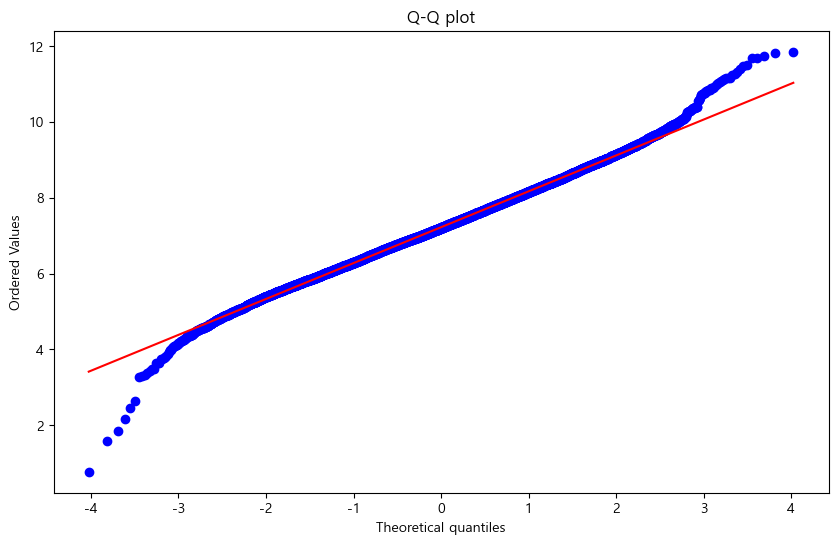

In [432]:
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()

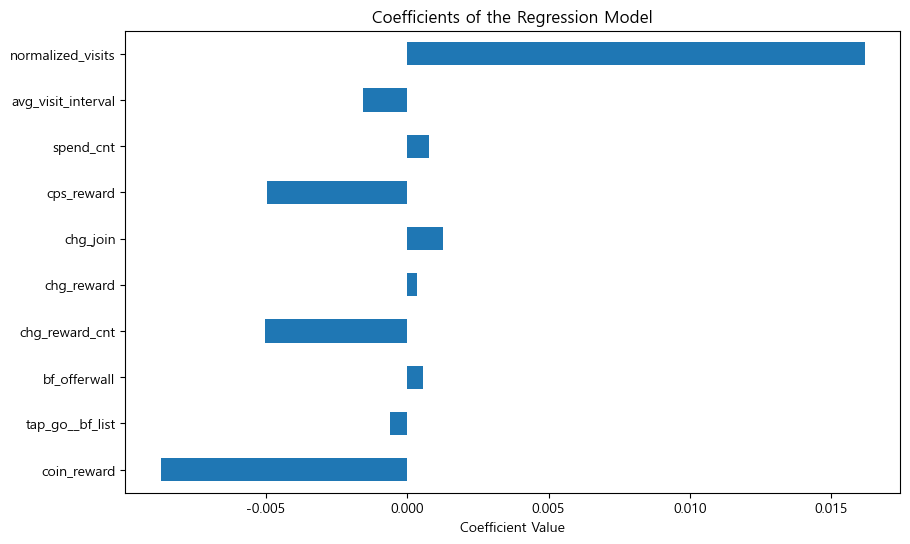

In [433]:
coef = pd.Series(model.params[1:], index=x.columns)  # 절편을 제외한 계수들
coef.plot(kind='barh', figsize=(10, 6))
plt.xlabel('Coefficient Value')
plt.title('Coefficients of the Regression Model')
plt.show()


#### 매출 분석

                                 OLS Regression Results                                
Dep. Variable:       total_commission   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.3992
Date:                Thu, 16 May 2024   Prob (F-statistic):                       0.948
Time:                        19:06:29   Log-Likelihood:                         -82821.
No. Observations:               24327   AIC:                                  1.657e+05
Df Residuals:                   24317   BIC:                                  1.657e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

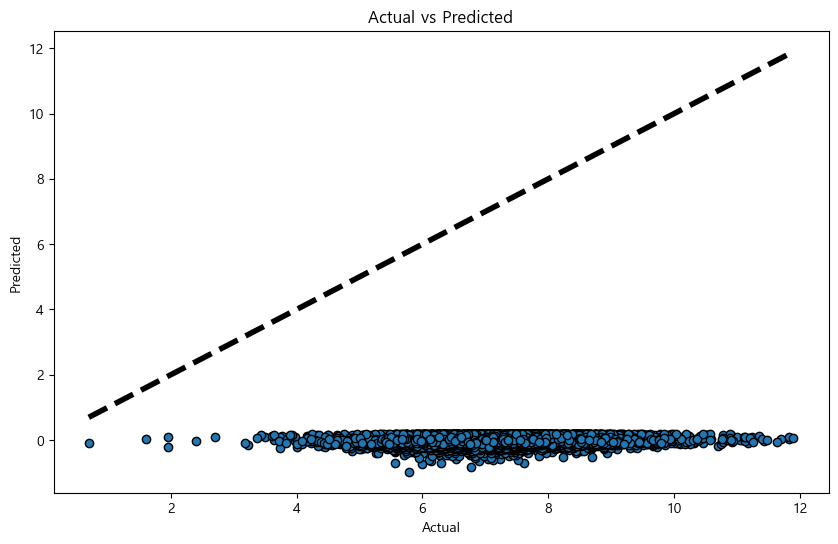

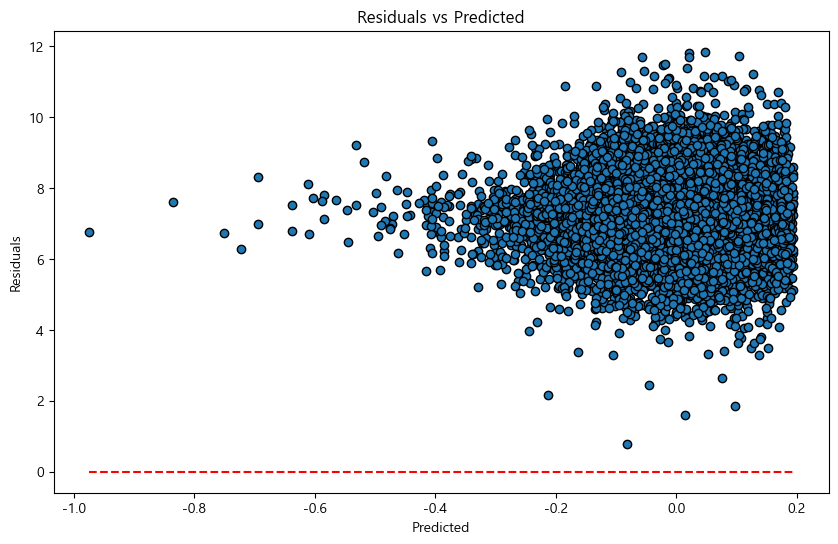

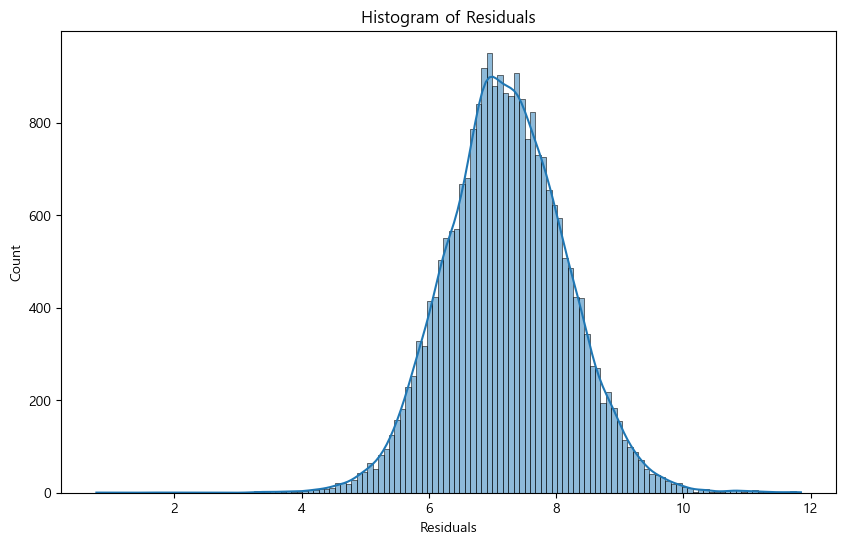

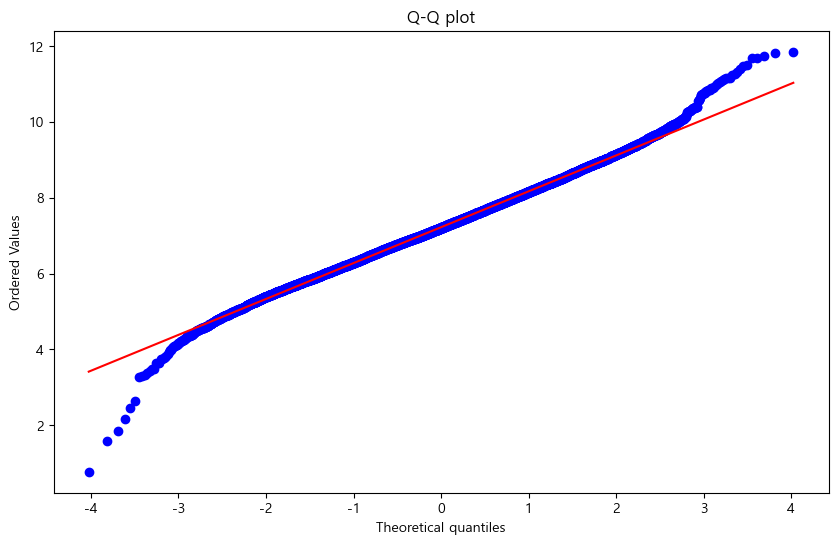

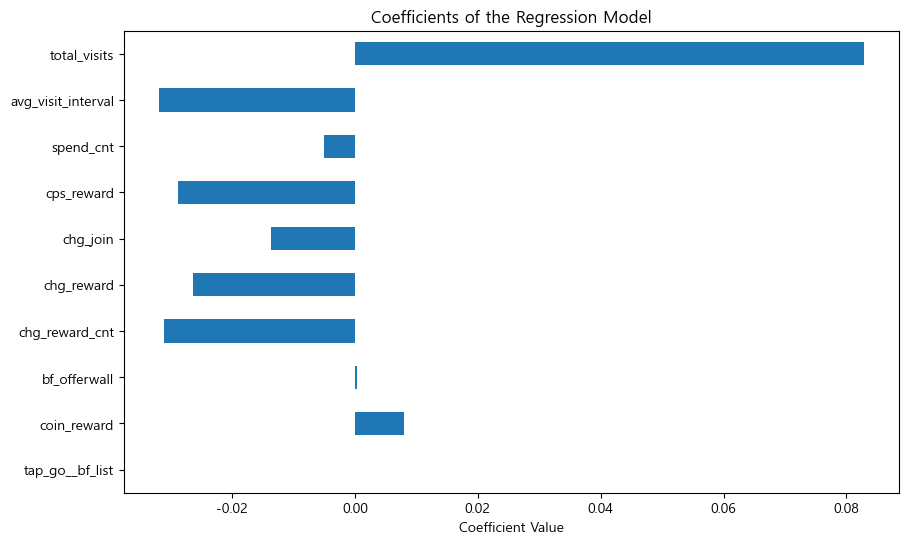

In [425]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# df4 = df2[['ID','tap_go__bf_list', 'bf_offerwall','cp_reward', 'chg_join','cps_reward','spend_cnt','avg_visit_interval','total_visits', 'total_commission']]
df4 = df2[['ID','tap_go__bf_list','coin_reward', 'bf_offerwall','chg_reward_cnt', 'chg_reward','chg_join','cps_reward','spend_cnt','avg_visit_interval', 'total_visits','total_commission']]
df4['total_commission'] = np.log1p(df['total_commission'])  # log(1 + revenue) 변환을 사용하여 0값 처리

y = df4.iloc[:,-1]
x = df4.iloc[:,1:-1]

# 스케일링
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# 스케일링 후 데이터프레임 변환
x_scaled_df = pd.DataFrame(data=x_scaled, columns=x.columns, index=x.index)

# 상수항 추가

# OLS 모델 생성 및 적합
model = sm.OLS(y, x_scaled_df).fit()

# 모델 요약 출력
print(model.summary())

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# 예측 값과 실제 값 비교
y_pred = model.predict(x_scaled_df)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, edgecolors=(0, 0, 0))
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# 잔차 플롯
residuals = y - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, edgecolors=(0, 0, 0))
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

# 잔차 히스토그램
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()

# Q-Q 플롯
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()

# 다중 회귀 분석의 중요 변수 플롯
coef = pd.Series(model.params[1:], index=x.columns)
coef.plot(kind='barh', figsize=(10, 6))
plt.xlabel('Coefficient Value')
plt.title('Coefficients of the Regression Model')
plt.show()


### 아웃라이어를 제외한다면?

In [454]:
df2_normal = df2.query("outlier==False")

                                 OLS Regression Results                                
Dep. Variable:       total_commission   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.2160
Date:                Thu, 16 May 2024   Prob (F-statistic):                       0.995
Time:                        19:23:59   Log-Likelihood:                         -78191.
No. Observations:               23081   AIC:                                  1.564e+05
Df Residuals:                   23071   BIC:                                  1.565e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

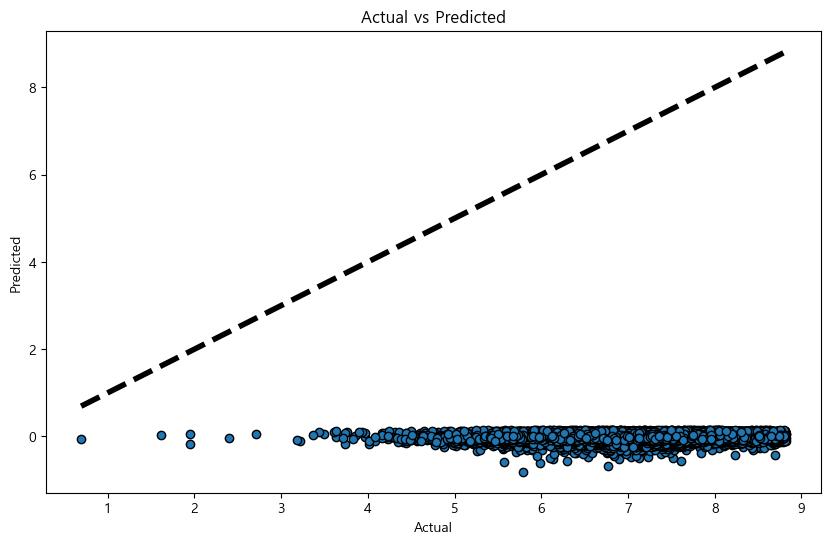

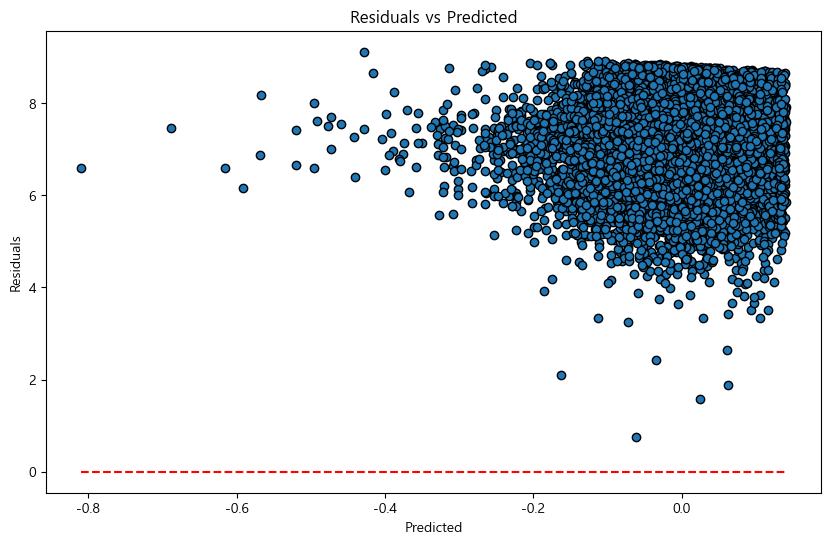

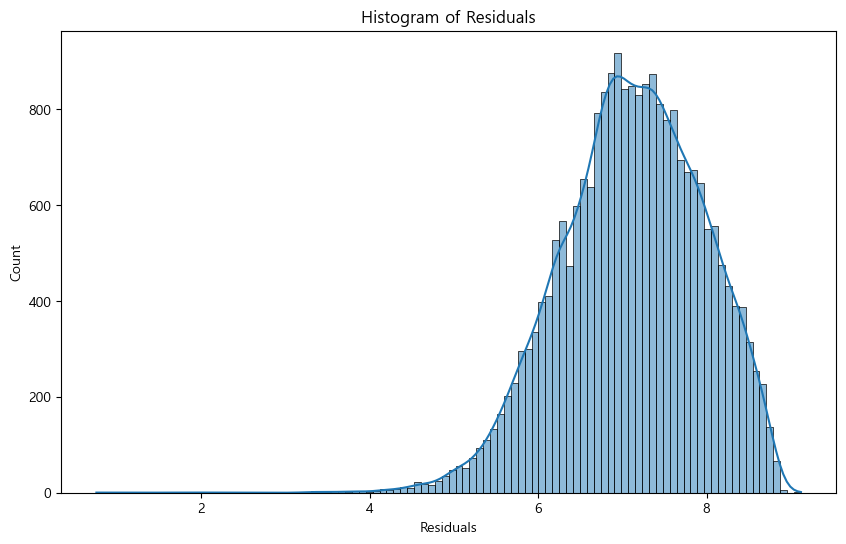

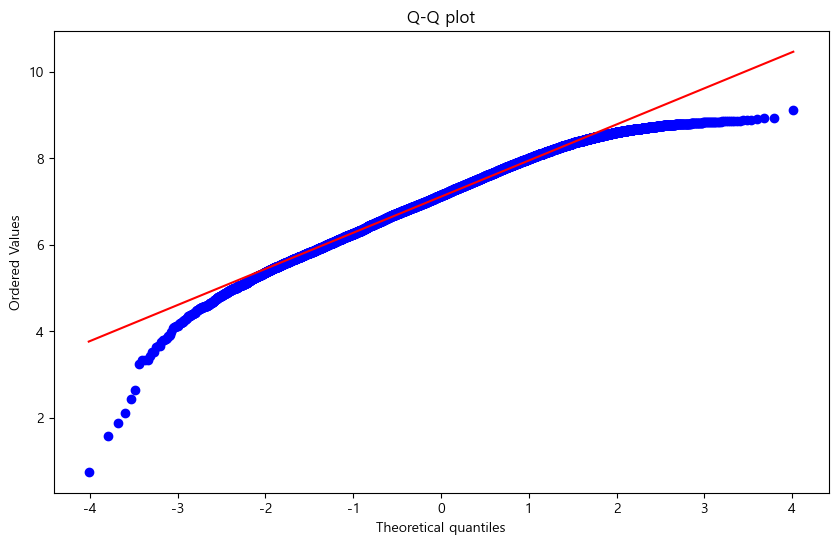

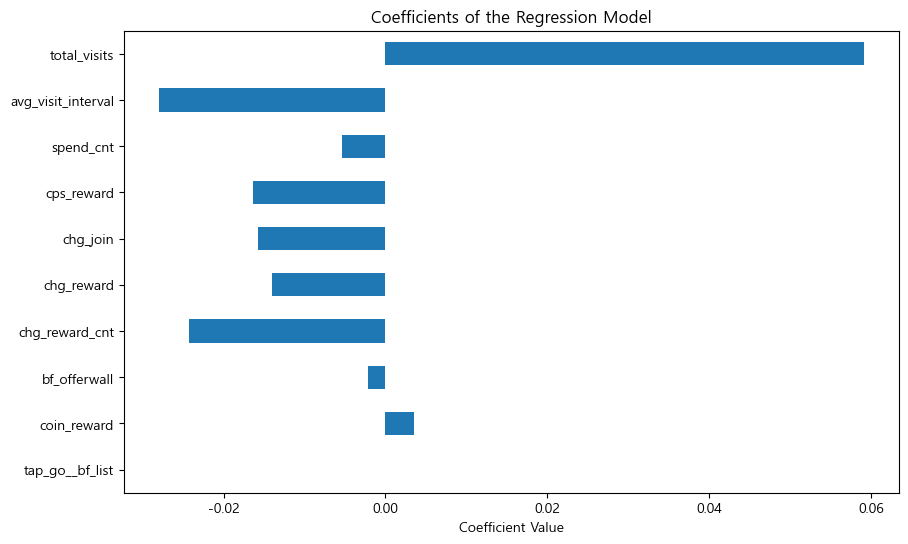

In [455]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# df4 = df2_normal[['ID','tap_go__bf_list', 'bf_offerwall','cp_reward', 'chg_join','cps_reward','spend_cnt','avg_visit_interval','total_visits', 'total_commission']]
df4 = df2_normal[['ID','tap_go__bf_list','coin_reward', 'bf_offerwall','chg_reward_cnt', 'chg_reward','chg_join','cps_reward','spend_cnt','avg_visit_interval', 'total_visits','total_commission']]
df4['total_commission'] = np.log1p(df['total_commission'])  # log(1 + revenue) 변환을 사용하여 0값 처리

y = df4.iloc[:,-1]
x = df4.iloc[:,1:-1]

# 스케일링
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# 스케일링 후 데이터프레임 변환
x_scaled_df = pd.DataFrame(data=x_scaled, columns=x.columns, index=x.index)

# 상수항 추가

# OLS 모델 생성 및 적합
model = sm.OLS(y, x_scaled_df).fit()

# 모델 요약 출력
print(model.summary())

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# 예측 값과 실제 값 비교
y_pred = model.predict(x_scaled_df)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, edgecolors=(0, 0, 0))
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# 잔차 플롯
residuals = y - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, edgecolors=(0, 0, 0))
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

# 잔차 히스토그램
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()

# Q-Q 플롯
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()

# 다중 회귀 분석의 중요 변수 플롯
coef = pd.Series(model.params[1:], index=x.columns)
coef.plot(kind='barh', figsize=(10, 6))
plt.xlabel('Coefficient Value')
plt.title('Coefficients of the Regression Model')
plt.show()


##### 매출을 랜덤포레스트로 수행해보자

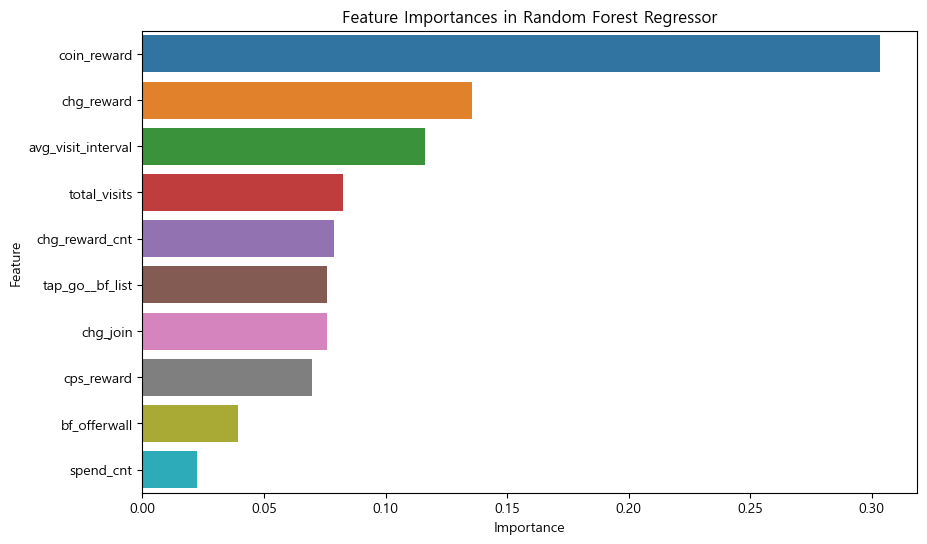

In [112]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

df4 = df2[['ID','tap_go__bf_list', 'bf_offerwall','cp_reward', 'cps_reward','spend_cnt','avg_visit_interval','total_visits', 'total_commission']]
df4 = df2[['ID','tap_go__bf_list','coin_reward', 'bf_offerwall','chg_reward_cnt', 'chg_reward','chg_join','cps_reward','spend_cnt','avg_visit_interval', 'total_visits','total_commission']]
df4['total_commission'] = np.log1p(df['total_commission'])  # log(1 + revenue) 변환을 사용하여 0값 처리

y = df4.iloc[:,-1]
x = df4.iloc[:,1:-1]

# 스케일링
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# 스케일링 후 데이터프레임 변환
x_scaled_df = pd.DataFrame(data=x_scaled, columns=x.columns, index=x.index)

# 랜덤 포레스트 회귀 모델 훈련
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_scaled, y)

# 변수 중요도 계산
importances = rf.feature_importances_
feature_names = x.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 변수 중요도 정렬
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Regressor')
plt.show()


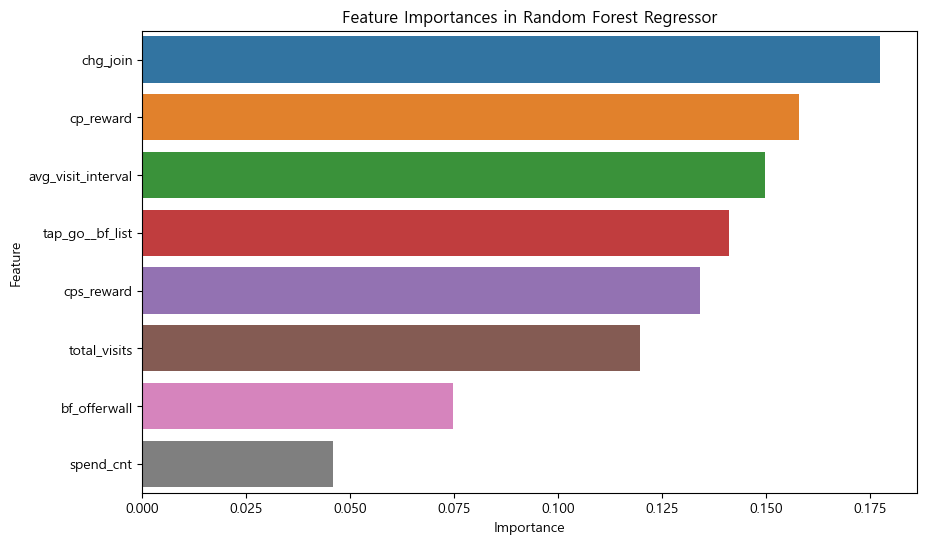

In [113]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

df4 = df2[['ID','tap_go__bf_list', 'bf_offerwall','cp_reward', 'chg_join','cps_reward','spend_cnt','avg_visit_interval','total_visits', 'orderDate']]
# df4['total_commission'] = np.log1p(df['total_commission'])  # log(1 + revenue) 변환을 사용하여 0값 처리

y = df4.iloc[:,-1]
x = df4.iloc[:,1:-1]

# 스케일링
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# 스케일링 후 데이터프레임 변환
x_scaled_df = pd.DataFrame(data=x_scaled, columns=x.columns, index=x.index)

# 랜덤 포레스트 회귀 모델 훈련
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(x_scaled, y)

# 변수 중요도 계산
importances = rf.feature_importances_
feature_names = x.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 변수 중요도 정렬
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Regressor')
plt.show()


### 흠..

In [485]:
print(len(df))
df = pd.merge(df,df_1[['ID','y']],on='ID',how='left')
print(len(df))

955864
955864


In [486]:
df['y'] = df['y'].fillna(0)

In [487]:
df

,ID,tap_go__bf_list,bf_offerwall,coin_reward,cp_reward,chg_reward,chg_reward_cnt,chg_join,cps_reward,spend,spend_cnt,ad_click_no_coupang,ad_click_coupang,avg_visit_interval,total_visits,y
0,fc8b6224-b27f-4fc2-a269-e8016268784b,0,0,12.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1,0.0
1,f280f2f5-8cba-4b32-a1ad-3a3fe82f3b0f,1,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1,0.0
2,ffe95162-15ff-4f01-bef7-2ff5cc9bf4b2,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1,0.0
3,1583310f-fb5c-4c9b-bd8e-657b5498d760,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1,0.0
4,f10a9a27-7b4c-4692-b113-9687295f7488,0,0,30.0,0.0,0.0,0,0,0.0,0.0,0,1,1,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955859,c83b58f9-d38a-45ae-b465-eaa52af42116,2,0,0.0,340.0,3497.0,37,13,0.0,0.0,0,2,0,1.0,37,0.0
955860,b70f2c6d-5f76-45e3-9400-4ad69f7f28a7,0,0,982.0,70.0,5699.0,37,15,0.0,0.0,0,7,5,1.0,37,1.0
955861,b48c0240-65ee-4910-b43a-150b22152fc5,7,0,825.0,60.0,3842.0,47,18,6.0,8571.0,3,19,15,1.0,37,0.0
955862,5f0b960a-7cd3-42ce-ba1a-fe4dcc1194ba,40,70,925.0,400.0,5848.0,37,15,167.0,0.0,0,10,6,1.0,37,0.0


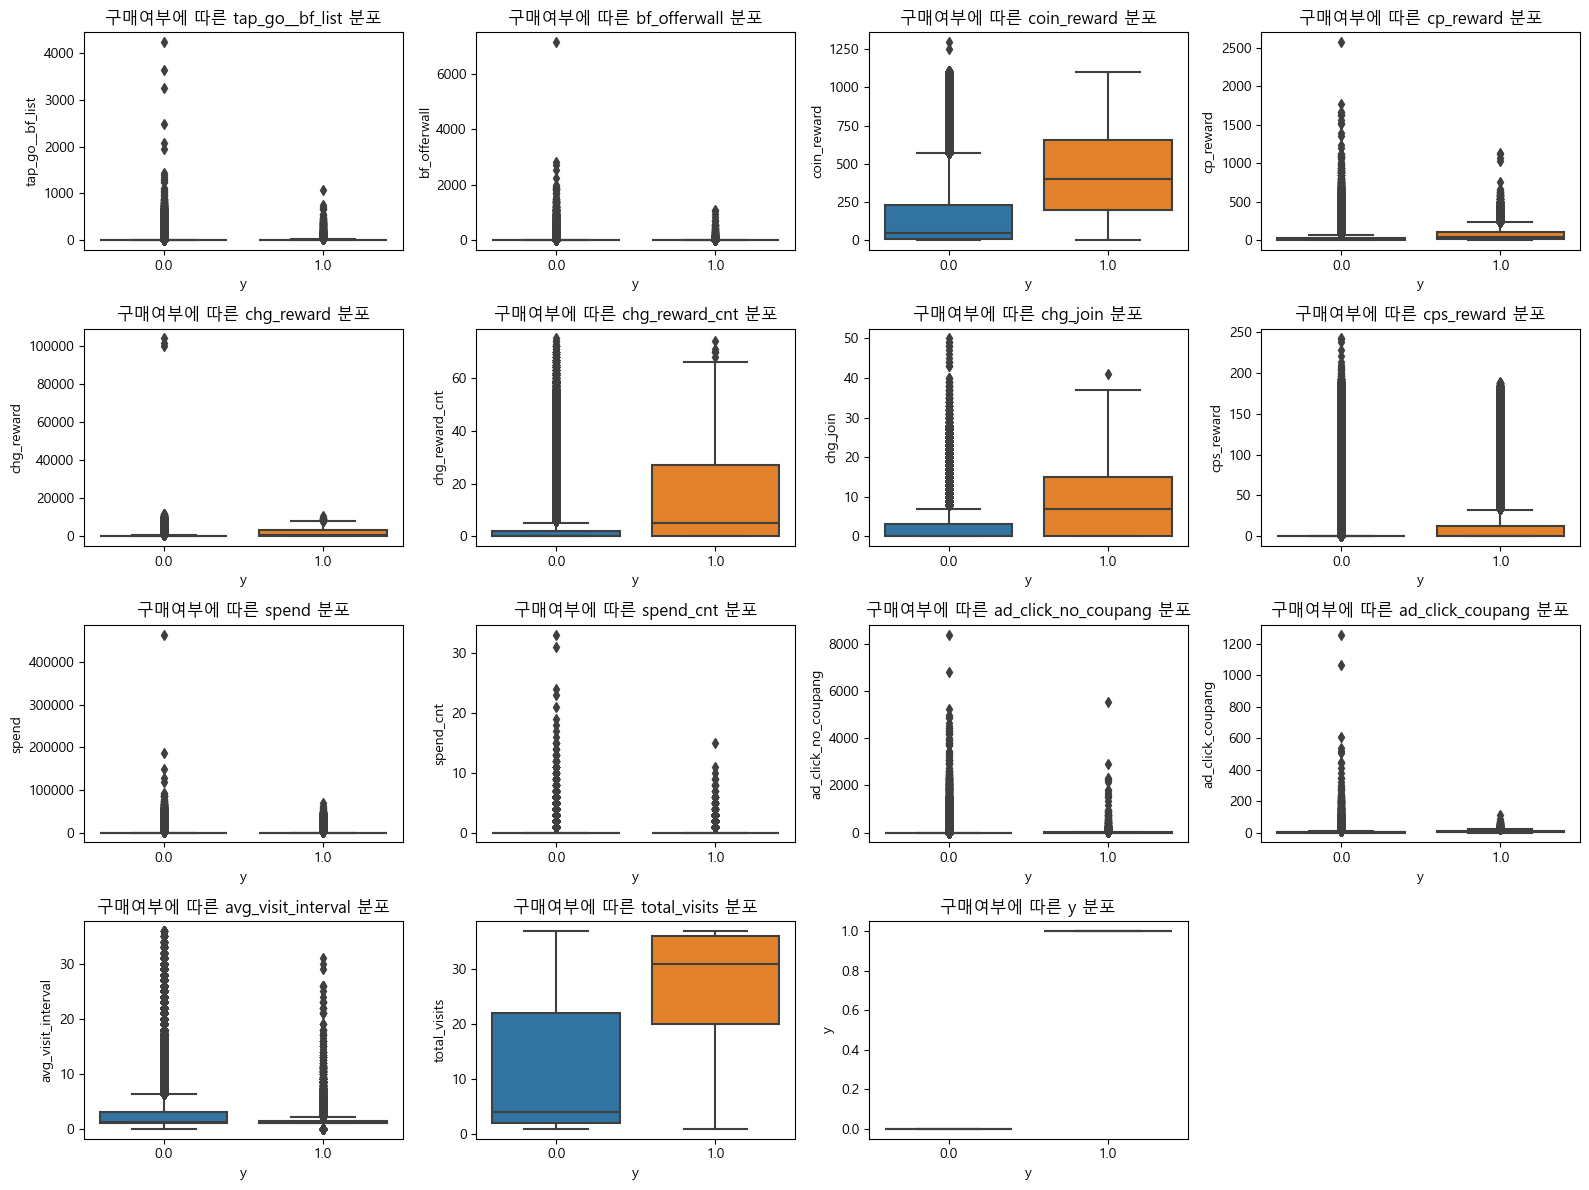

In [490]:
plt.figure(figsize=(16, 12))
features = ['tap_go__bf_list', 'bf_offerwall', 'coin_reward', 'cp_reward',
            'chg_reward', 'chg_reward_cnt', 'chg_join', 'cps_reward', 'spend',
            'spend_cnt', 'ad_click_no_coupang', 'ad_click_coupang',
            'avg_visit_interval', 'total_visits','y']

for i, feature in enumerate(features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='y', y=feature, data=df)
    plt.title(f'구매여부에 따른 {feature} 분포')

plt.tight_layout()
plt.show()

In [492]:
from scipy.stats import ttest_ind

# 각 피처에 대한 t-검정
for feature in features:
    buyers = df[df['y'] == 1][feature]
    non_buyers = df[df['y'] == 0][feature]
    
    t_stat, p_value = ttest_ind(buyers, non_buyers, equal_var=False)
    print(f'{feature}: t-statistic = {t_stat:.2f}, p-value = {p_value:.2e}')


tap_go__bf_list: t-statistic = 23.64, p-value = 2.59e-122
bf_offerwall: t-statistic = 4.68, p-value = 2.84e-06
coin_reward: t-statistic = 139.63, p-value = 0.00e+00
cp_reward: t-statistic = 54.12, p-value = 0.00e+00
chg_reward: t-statistic = 81.85, p-value = 0.00e+00
chg_reward_cnt: t-statistic = 80.24, p-value = 0.00e+00
chg_join: t-statistic = 101.76, p-value = 0.00e+00
cps_reward: t-statistic = 34.66, p-value = 1.66e-257
spend: t-statistic = 26.02, p-value = 2.17e-147
spend_cnt: t-statistic = 29.10, p-value = 2.71e-183
ad_click_no_coupang: t-statistic = 10.58, p-value = 4.02e-26
ad_click_coupang: t-statistic = 96.34, p-value = 0.00e+00
avg_visit_interval: t-statistic = -104.17, p-value = 0.00e+00
total_visits: t-statistic = 230.48, p-value = 0.00e+00
y: t-statistic = inf, p-value = 0.00e+00


In [494]:
def bootstrap_mean(df, n_bootstrap=1000):
    means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(df, size=len(df), replace=True)
        means.append(np.mean(sample))
    return np.percentile(means, [2.5, 97.5])

# total_visits에 대한 부트스트랩 신뢰구간
buyers_visits = df[df['y'] == 1]['total_visits']
non_buyers_visits = df[df['y'] == 0]['total_visits']

buyers_ci = bootstrap_mean(buyers_visits)
non_buyers_ci = bootstrap_mean(non_buyers_visits)

print(f'구매자 total_visits 신뢰구간: {buyers_ci}')
print(f'비구매자 total_visits 신뢰구간: {non_buyers_ci}')


구매자 total_visits 신뢰구간: [27.11323728 27.36172519]
비구매자 total_visits 신뢰구간: [11.93014262 11.98501471]


In [496]:
df

,ID,tap_go__bf_list,bf_offerwall,coin_reward,cp_reward,chg_reward,chg_reward_cnt,chg_join,cps_reward,spend,spend_cnt,ad_click_no_coupang,ad_click_coupang,avg_visit_interval,total_visits,y,total_activity
0,fc8b6224-b27f-4fc2-a269-e8016268784b,0,0,12.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1,0.0,13.0
1,f280f2f5-8cba-4b32-a1ad-3a3fe82f3b0f,1,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1,0.0,2.0
2,ffe95162-15ff-4f01-bef7-2ff5cc9bf4b2,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1,0.0,1.0
3,1583310f-fb5c-4c9b-bd8e-657b5498d760,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,1,0.0,1.0
4,f10a9a27-7b4c-4692-b113-9687295f7488,0,0,30.0,0.0,0.0,0,0,0.0,0.0,0,1,1,0.0,1,0.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955859,c83b58f9-d38a-45ae-b465-eaa52af42116,2,0,0.0,340.0,3497.0,37,13,0.0,0.0,0,2,0,1.0,37,0.0,3929.0
955860,b70f2c6d-5f76-45e3-9400-4ad69f7f28a7,0,0,982.0,70.0,5699.0,37,15,0.0,0.0,0,7,5,1.0,37,1.0,6853.0
955861,b48c0240-65ee-4910-b43a-150b22152fc5,7,0,825.0,60.0,3842.0,47,18,6.0,8571.0,3,19,15,1.0,37,0.0,13451.0
955862,5f0b960a-7cd3-42ce-ba1a-fe4dcc1194ba,40,70,925.0,400.0,5848.0,37,15,167.0,0.0,0,10,6,1.0,37,0.0,7556.0


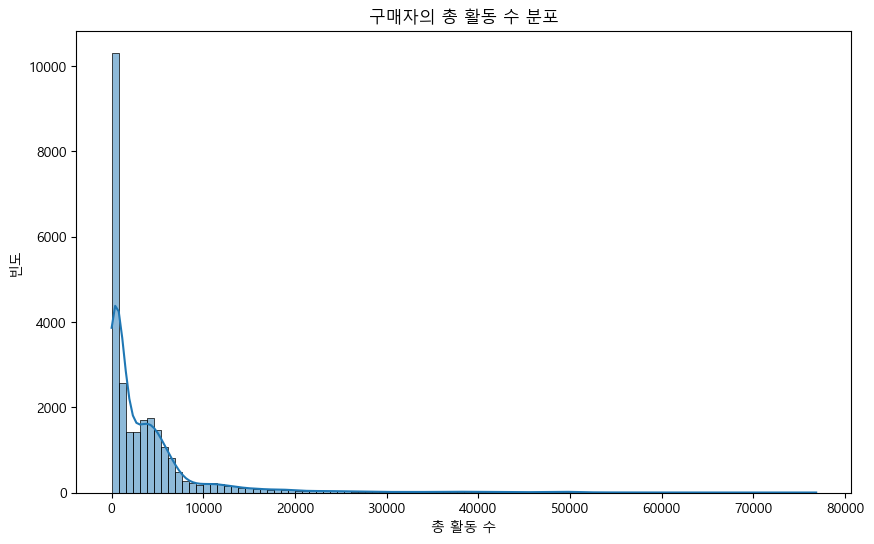

In [500]:
# 예제 기준: 모든 활동의 합계가 10 이하인 사용자는 노이즈로 간주
# activity_columns = ['tap_go__bf_list', 'bf_offerwall', 'coin_reward', 'cp_reward', 
#                     'chg_reward', 'chg_reward_cnt', 'chg_join', 'cps_reward', 
#                     'spend', 'spend_cnt', 'ad_click_no_coupang', 'ad_click_coupang', 
#                     'avg_visit_interval', 'total_visits']
# df['total_activity'] = df[activity_columns].sum(axis=1)

df.query("y==1")['total_activity'].mean()
purchaser_activity = df.query("y==1")['total_activity']

plt.figure(figsize=(10, 6))
sns.histplot(purchaser_activity, bins=100, kde=True)
plt.title('구매자의 총 활동 수 분포')
plt.xlabel('총 활동 수')
plt.ylabel('빈도')
plt.show()
# # 노이즈 유저 정의
# noise_threshold = 10
# df['total_activity'] <= noise_threshold


In [558]:
# 구매자 중 활동성 하위 5% 삭제. 해당 기준을 노이즈 바로 적용
print(len(df[(df['y']==1) & (df['total_activity']<20)]) / len(df[(df['y']==1)]))

noise_threshold = 20

# 실제 사용자 필터링 (노이즈 유저 제거)
df_5 = df[df['total_activity']>20]

0.013898513898513898


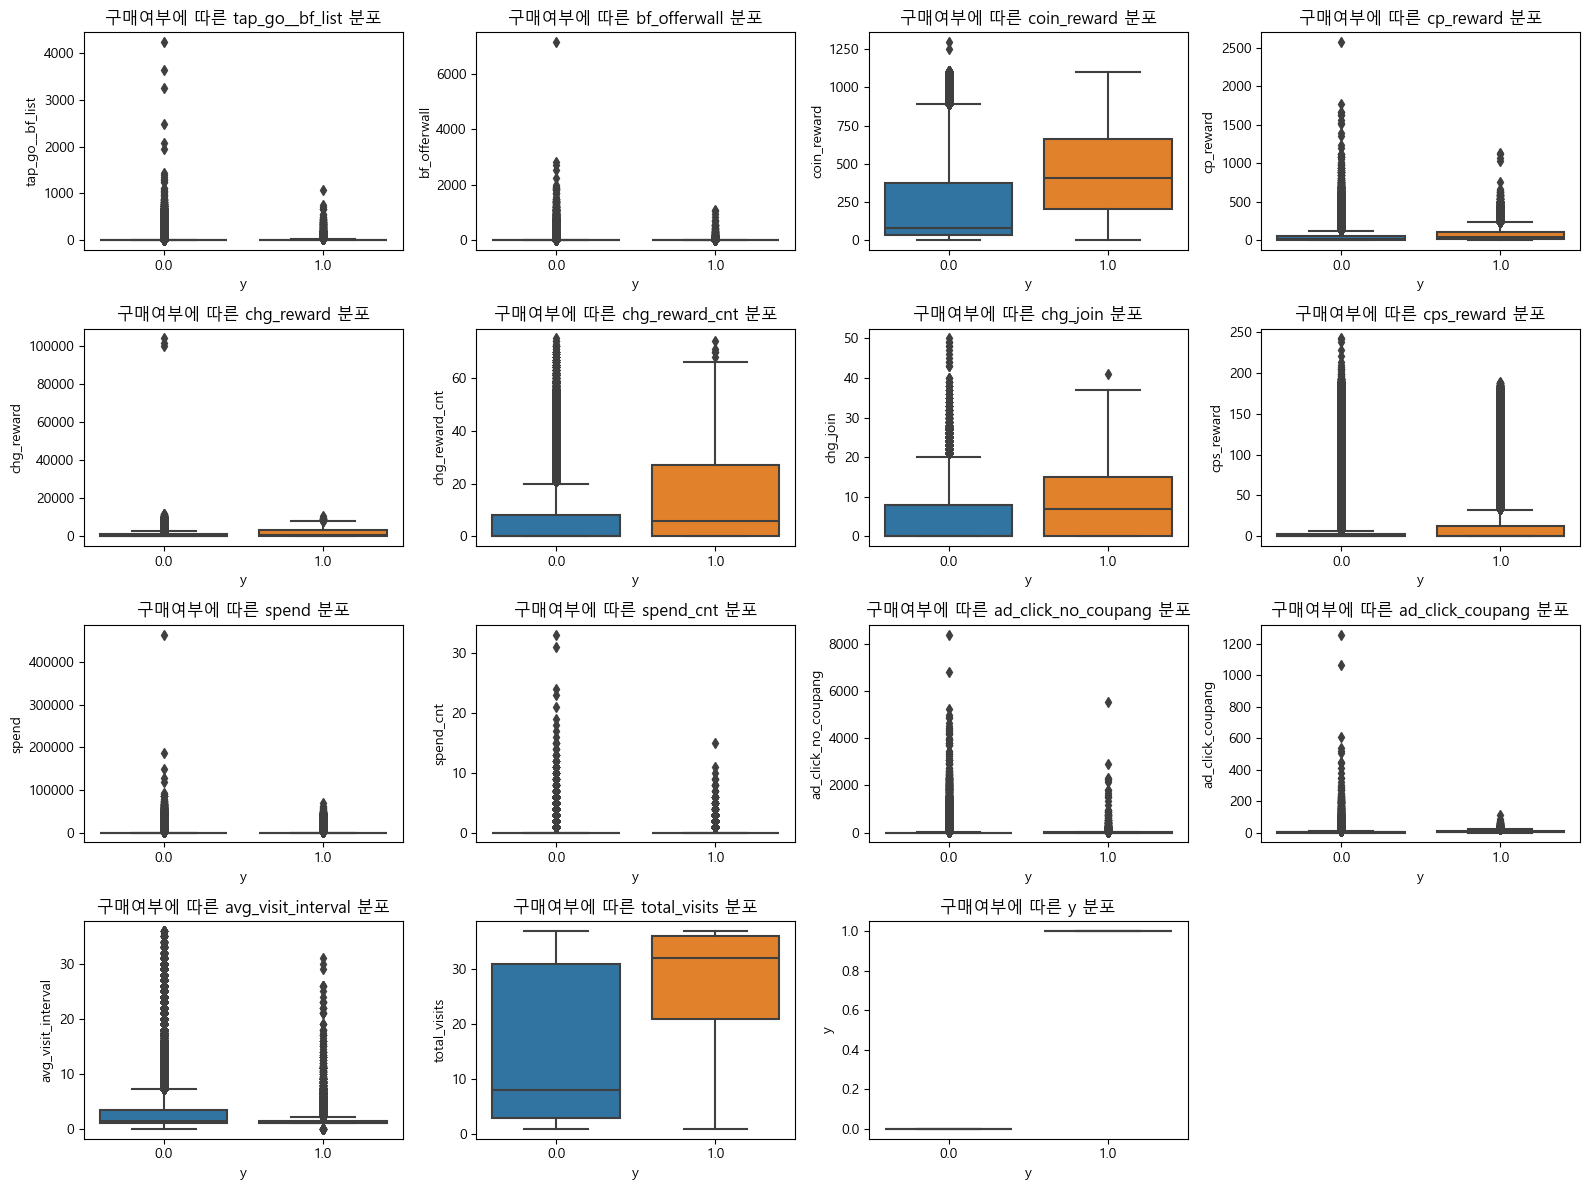

In [559]:
plt.figure(figsize=(16, 12))
features = ['tap_go__bf_list', 'bf_offerwall', 'coin_reward', 'cp_reward',
            'chg_reward', 'chg_reward_cnt', 'chg_join', 'cps_reward', 'spend',
            'spend_cnt', 'ad_click_no_coupang', 'ad_click_coupang',
            'avg_visit_interval', 'total_visits','y']

for i, feature in enumerate(features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='y', y=feature, data=df_5)
    plt.title(f'구매여부에 따른 {feature} 분포')

plt.tight_layout()
plt.show()

In [520]:
df_5.columns

Index(['ID', 'tap_go__bf_list', 'bf_offerwall', 'coin_reward', 'cp_reward',
       'chg_reward', 'chg_reward_cnt', 'chg_join', 'cps_reward', 'spend',
       'spend_cnt', 'ad_click_no_coupang', 'ad_click_coupang',
       'avg_visit_interval', 'total_visits', 'y', 'total_activity'],
      dtype='object')

In [560]:
activity_columns = ['tap_go__bf_list', 'bf_offerwall', 'coin_reward', 'cp_reward', 
                    'chg_reward', 'chg_reward_cnt', 'chg_join', 'cps_reward', 
                    'spend', 'spend_cnt', 'ad_click_no_coupang', 'ad_click_coupang', 
                    'avg_visit_interval', 'total_visits']

Cross-validated Recall: 0.83


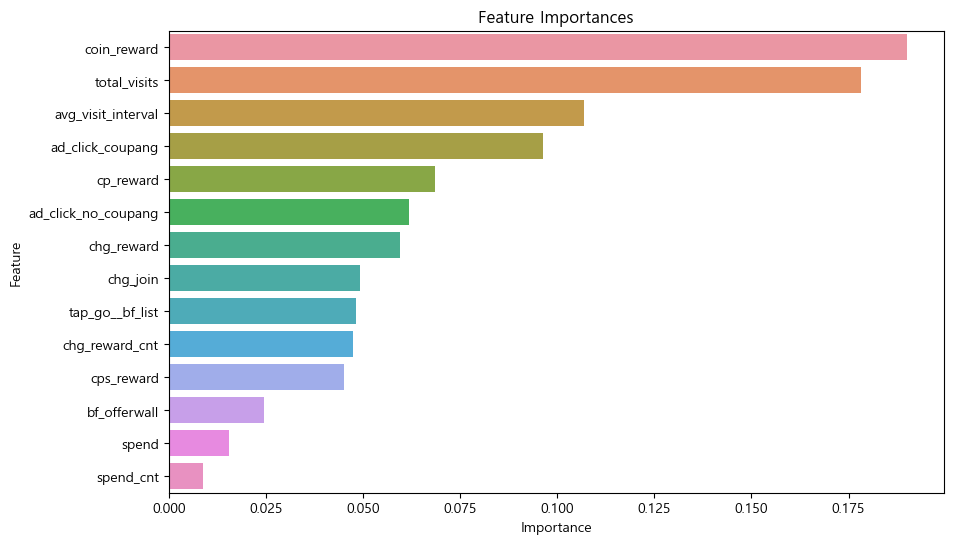

In [561]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 총 활동 수 계산
activity_columns = ['tap_go__bf_list', 'bf_offerwall', 'coin_reward', 'cp_reward', 
                    'chg_reward', 'chg_reward_cnt', 'chg_join', 'cps_reward', 
                    'spend', 'spend_cnt', 'ad_click_no_coupang', 'ad_click_coupang', 
                    'avg_visit_interval', 'total_visits']
df['total_activity'] = df[activity_columns].sum(axis=1)


# 언더샘플링을 위한 데이터 분리
non_purchasers = df_5[df_5['y'] == 0]
purchasers = df_5[df_5['y'] == 1]

# 언더샘플링 비율 설정
non_purchasers_sample = non_purchasers.sample(n=len(purchasers), random_state=42)
under_sampled = pd.concat([purchasers, non_purchasers_sample])

# 데이터 분리
X = under_sampled[activity_columns]
y = under_sampled['y']

# 교차 검증 설정
kf = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)

# 모델 학습 및 평가
rf = RandomForestClassifier(random_state=42)
recalls = []
importances = []

# 교차 검증
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    recalls.append(recall_score(y_test, y_pred))
    importances.append(rf.feature_importances_)

# 평균 recall 및 중요도 계산
mean_recall = np.mean(recalls)
mean_importances = np.mean(importances, axis=0)

print(f'Cross-validated Recall: {mean_recall:.2f}')

# 중요도 시각화
feature_importances = pd.DataFrame({'Feature': activity_columns, 'Importance': mean_importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

In [562]:
sum(y_pred), sum(y_test)

(583.0, 511.0)

In [563]:
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred))

# recall 평가
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.67      0.72       512
         1.0       0.71      0.81      0.75       511

    accuracy                           0.74      1023
   macro avg       0.74      0.74      0.73      1023
weighted avg       0.74      0.74      0.73      1023

Recall: 0.81


샘플링을 통한 피쳐 차이 확인

In [575]:
df[df['y']==1]['chg_join'].mean()


7.867829367829368

In [574]:
df_5[df_5['y']==0]['chg_join'].mean()


4.317516487744373

In [568]:
from tqdm import tqdm

activity_columns = ['tap_go__bf_list', 'bf_offerwall', 'coin_reward', 'cp_reward', 
                    'chg_reward', 'chg_reward_cnt', 'chg_join', 'cps_reward', 
                    'spend', 'spend_cnt', 'ad_click_no_coupang', 'ad_click_coupang', 
                    'avg_visit_interval', 'total_visits']

# 구매자와 비구매자 분리
purchasers = df_5[df_5['y'] == 1]
non_purchasers = df_5[df_5['y'] == 0]

# total_activity를 이산형 변수로 변환
bins = np.linspace(0, non_purchasers['total_activity'].max(), 10)
non_purchasers['activity_bin'] = np.digitize(non_purchasers['total_activity'], bins)

# 부트스트래핑 및 베이지안 AB 테스트
n_bootstraps = 2000
results = {}

for feature in tqdm(activity_columns):
    purchaser_means = []
    non_purchaser_means = []

    for _ in range(n_bootstraps):
        # 구매자 부트스트랩 샘플
        purchaser_sample = np.random.choice(purchasers[feature].values, size=len(purchasers), replace=True)
        purchaser_means.append(purchaser_sample.mean())
        
        # 비구매자 부트스트랩 샘플
        non_purchaser_sample = np.random.choice(non_purchasers[feature].values, size=len(non_purchasers), replace=True)
        non_purchaser_means.append(non_purchaser_sample.mean())
    
    purchaser_means = np.array(purchaser_means)
    non_purchaser_means = np.array(non_purchaser_means)
    
    # 베이지안 비교
    diff_means = purchaser_means - non_purchaser_means
    p_value = np.mean(diff_means > 0)  # 확률 면적 비교
    
    results[feature] = {
        'purchaser_mean': np.mean(purchaser_means),
        'non_purchaser_mean': np.mean(non_purchaser_means),
        'p_value': p_value
    }

# 결과 출력
for feature, result in results.items():
    print(f"{feature}:")
    print(f"  Purchaser mean: {result['purchaser_mean']:.2f}")
    print(f"  Non-purchaser mean: {result['non_purchaser_mean']:.2f}")
    print(f"  Probability purchaser > non-purchaser: {result['p_value']:.2f}")

# # 시각화 (예시)
# feature_to_plot = 'tap_go__bf_list'
# purchaser_means = bootstrap_samples(purchasers[feature_to_plot].values, n_bootstraps).mean(axis=1)
# non_purchaser_means = bootstrap_samples(non_purchasers[feature_to_plot].values, n_bootstraps).mean(axis=1)

# plt.figure(figsize=(10, 6))
# sns.kdeplot(purchaser_means, label='Purchasers', shade=True)
# sns.kdeplot(non_purchaser_means, label='Non-purchasers', shade=True)
# plt.title(f"Bootstrap Distributions for {feature_to_plot}")
# plt.xlabel('Mean Value')
# plt.ylabel('Density')
# plt.legend()
# plt.show()

100%|██████████| 14/14 [04:48<00:00, 20.63s/it]

tap_go__bf_list:
  Purchaser mean: 11.20
  Non-purchaser mean: 8.85
  Probability purchaser > non-purchaser: 1.00
bf_offerwall:
  Purchaser mean: 2.33
  Non-purchaser mean: 2.17
  Probability purchaser > non-purchaser: 0.87
coin_reward:
  Purchaser mean: 445.74
  Non-purchaser mean: 242.61
  Probability purchaser > non-purchaser: 1.00
cp_reward:
  Purchaser mean: 93.23
  Non-purchaser mean: 66.13
  Probability purchaser > non-purchaser: 1.00
chg_reward:
  Purchaser mean: 1705.65
  Non-purchaser mean: 954.05
  Probability purchaser > non-purchaser: 1.00
chg_reward_cnt:
  Purchaser mean: 13.84
  Non-purchaser mean: 7.63
  Probability purchaser > non-purchaser: 1.00
chg_join:
  Purchaser mean: 7.98
  Non-purchaser mean: 4.32
  Probability purchaser > non-purchaser: 1.00
cps_reward:
  Purchaser mean: 28.01
  Non-purchaser mean: 21.11
  Probability purchaser > non-purchaser: 1.00
spend:
  Purchaser mean: 1580.08
  Non-purchaser mean: 892.32
  Probability purchaser > non-purchaser: 1.00
spen

In [567]:
import gc


In [570]:
pd.DataFrame(results)

,tap_go__bf_list,bf_offerwall,coin_reward,cp_reward,chg_reward,chg_reward_cnt,chg_join,cps_reward,spend,spend_cnt,ad_click_no_coupang,ad_click_coupang,avg_visit_interval,total_visits
purchaser_mean,11.201970,2.332317,445.744775,93.233293,1705.654855,13.843255,7.982051,28.012813,1580.075945,0.208083,8.647285,7.597042,1.532827,27.603302
non_purchaser_mean,8.846286,2.172384,242.605682,66.129314,954.049311,7.627237,4.317800,21.110810,892.318821,0.119867,5.816280,4.028229,2.852760,15.385371
p_value,1.000000,0.870000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000


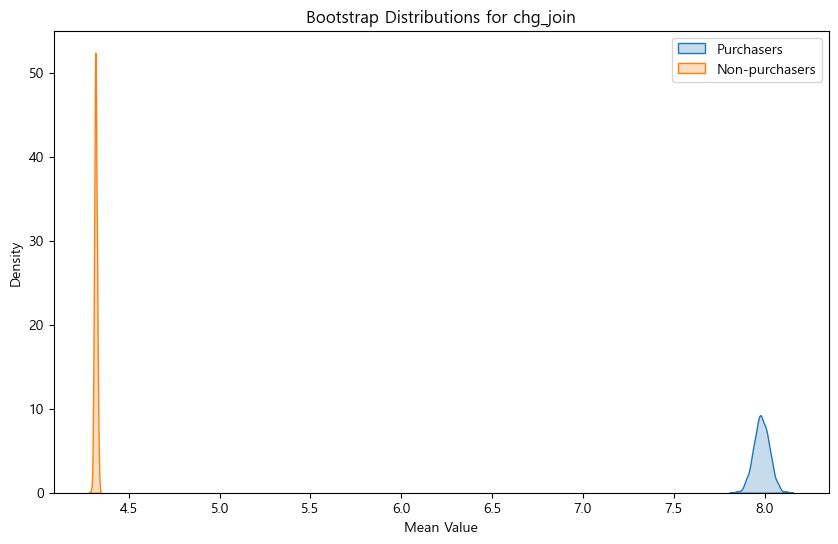

In [569]:
feature_to_plot = 'chg_join'
purchaser_means = bootstrap_samples(purchasers[feature_to_plot].values, n_bootstraps).mean(axis=1)
non_purchaser_means = bootstrap_samples(non_purchasers[feature_to_plot].values, n_bootstraps).mean(axis=1)

plt.figure(figsize=(10, 6))
sns.kdeplot(purchaser_means, label='Purchasers', shade=True)
sns.kdeplot(non_purchaser_means, label='Non-purchasers', shade=True)
plt.title(f"Bootstrap Distributions for {feature_to_plot}")
plt.xlabel('Mean Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [581]:
pcs = df[df['y']==1]

In [591]:
purchasers.columns

Index(['ID', 'tap_go__bf_list', 'bf_offerwall', 'coin_reward', 'cp_reward',
       'chg_reward', 'chg_reward_cnt', 'chg_join', 'cps_reward', 'spend',
       'spend_cnt', 'ad_click_no_coupang', 'ad_click_coupang',
       'avg_visit_interval', 'total_visits', 'total_gmv', 'total_commission',
       'total_quantity', 'orderDate', 'zscore', 'outlier', 'range', 'age',
       'sex', 'join_date', 'total_ch_join', 'predicted'],
      dtype='object')